<a href="https://colab.research.google.com/github/enznoor/AnomalyDetection/blob/main/FIP_Libra_FinalMyModel_SiameseNetwork_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dgl
!pip install node2vec
!pip install -q torch-geometric

In [ ]:
from node2vec.edges import HadamardEmbedder
from gensim.models import Word2Vec
import random
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import torch.optim as optim
import dgl.function as fn
from dgl.nn import SAGEConv

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
from google.colab import drive
import networkx as nx
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
#from dgl.nn import GraphConv
#from dgl.nn import SAGEConv
from torch_geometric.nn import GATConv
import dgl.nn as dglnn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
path='drive/MyDrive/Term_05/FinalProposal/Data/'
Finalpath='drive/MyDrive/Term_05/FinalProposal/FinalData/'
Finalpath_test='drive/MyDrive/Term_05/FinalProposal/FinalData_test/'
pathCommunity='drive/MyDrive/Term_05/FinalProposal/Data/Community/'
train_edge_index=np.load(path+'train_edge_index.npy')
train_edgelist=np.load(path+'train_edgelist.npy')
train_edge_weight=np.load(path+'train_edge_weight.npy')
train_x=np.load(path+'train_x.npy')
train_y=np.load(path+'train_y.npy')
test_edge_index=np.load(path+'test_edge_index.npy')
test_edgelist=np.load(path+'test_edgelist.npy')
test_edge_weight=np.load(path+'test_edge_weight.npy')
test_x=np.load(path+'test_x.npy')
test_y=np.load(path+'test_y.npy')
train_elabel=np.load(path+'edge_y_train.npy')
test_elabel=np.load(path+'edge_y_test.npy')

In [ ]:
nodedf=pd.read_csv(path + 'LibraReduceNodeInfo.csv')
edgedf=pd.read_csv(path + 'LibraReduceEdgeInfo.csv')

In [ ]:
print(edgedf.shape)
print(nodedf.shape)

(370918, 6)
(202426, 22)


In [ ]:
loaded_trainData=np.load(path+'train_node.npy')
loaded_testData=np.load(path+'test_node.npy')
traindf= pd.DataFrame(loaded_trainData, columns=['NewNodeId'])
testdf= pd.DataFrame(loaded_testData, columns=['NewNodeId'])

traindf['NewNodeId'] = traindf['NewNodeId'].astype(int)
traindata_df = pd.merge(traindf,nodedf, on='NewNodeId', how='inner')
testdata_df = pd.merge(testdf,nodedf, on='NewNodeId', how='inner')

In [ ]:
train_idx=torch.tensor(traindata_df.index, dtype = torch.long)
test_idx=torch.tensor(testdata_df.index, dtype = torch.long)
#valid_idx=torch.tensor(validate.index, dtype = torch.long)

In [ ]:
edgedf.insert(1, "elabel", 0)
edgedf["elabel"] = np.where(edgedf["nr_alerts"] > 0, 1, 0)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ,'elabel' ]
G=nx.from_pandas_edgelist(
            df=edgedf,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',G.number_of_edges())
print('number_of_nodes: ',G.number_of_nodes())

number_of_edges:  370918
number_of_nodes:  202426


# Create Train and Test Graph for edge Classification

In [ ]:
df1=pd.DataFrame(train_edgelist)
df2=pd.DataFrame(train_edge_weight)
train_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#-------------------------------------------------------------------------------
train_edgelist_G = train_edgelist_G.rename(columns={'0_x': 'id_source'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_x': 'id_destination'})
train_edgelist_G = train_edgelist_G.rename(columns={'0_y': 'cum_amount'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
train_edgelist_G['eLabel']=pd.DataFrame(train_elabel)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
train_G=nx.from_pandas_edgelist(
            df=train_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',train_G.number_of_edges())
print('number_of_nodes: ',train_G.number_of_nodes())

number_of_edges:  230907
number_of_nodes:  135447


In [ ]:
df1=pd.DataFrame(test_edgelist)
df2=pd.DataFrame(test_edge_weight)
test_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#-------------------------------------------------------------------------------
test_edgelist_G = test_edgelist_G.rename(columns={'0_x': 'id_source'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_x': 'id_destination'})
test_edgelist_G = test_edgelist_G.rename(columns={'0_y': 'cum_amount'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
test_edgelist_G['eLabel']=pd.DataFrame(test_elabel)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
test_G=nx.from_pandas_edgelist(
            df=test_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',test_G.number_of_edges())
print('number_of_nodes: ',test_G.number_of_nodes())

number_of_edges:  16222
number_of_nodes:  12963


In [ ]:
#train_G = G.subgraph(loaded_trainData)
#test_G = G.subgraph(loaded_testData)
print('number_of_edges train_graph: ',train_G.number_of_edges())
print('number_of_nodes train_graph: ',train_G.number_of_nodes())
print('number_of_edges test_graph: ',test_G.number_of_edges())
print('number_of_nodes test_graph: ',test_G.number_of_nodes())


number_of_edges train_graph:  230907
number_of_nodes train_graph:  135447
number_of_edges test_graph:  16222
number_of_nodes test_graph:  12963


# Set Attribute  to Train and Test Graph

In [ ]:
trainNode_G=list(train_G.nodes())
trainNode=pd.DataFrame(trainNode_G, columns=['NewNodeId'])
traindata_df = pd.merge(trainNode,nodedf, on='NewNodeId', how='inner')

testNode_G=list(test_G.nodes())
testNode=pd.DataFrame(testNode_G, columns=['NewNodeId'])
testdata_df = pd.merge(testNode,nodedf, on='NewNodeId', how='inner')

In [ ]:
col=['NewNodeId']
df1=traindata_df[col].where(traindata_df['L_alert'] ==1).dropna()
df2=testdata_df[col].where(testdata_df['L_alert'] ==1).dropna()
ListAnomalNode_train=df1['NewNodeId'].values.tolist()
ListAnomalNode_test=df2['NewNodeId'].values.tolist()

In [ ]:
len(ListAnomalNode_test)

74

# Create Model

In [ ]:
# Define the Siamese Network architecture
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim ):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward_one(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        #return F.log_softmax(euclidean_distance)
        return torch.sigmoid(euclidean_distance)

# Define the contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, target):
        loss = torch.mean((1 - target) * torch.pow(output, 2) +
                          target * torch.pow(torch.clamp(self.margin - output, min=0.0), 2))
        return loss

In [ ]:
from torch.utils.data import DataLoader, Dataset
# Define a custom dataset for loading transaction data
class TransactionDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    return model


In [ ]:
# def evaluate(model,test_loader , edge_index):
#     torch.backends.cudnn.deterministic = True
#     model.eval()
#     with torch.no_grad():
#         for data in test_loader:
#             inputs, labels = data
#             logits = model(inputs, edge_index)
#             _, predicted = torch.max(logits, 1)

#             accuracy = (predicted == labels).float().mean().item()


#         print(classification_report(labels, predicted))

#     #--------------------Plot AUC----------------------------
#         fpr, tpr, thresholds = roc_curve(labels, predicted)

#         # Calculate the AUC
#         roc_auc = auc(fpr, tpr)
#         # Calculate the AUC
#         roc_auc = auc(fpr, tpr)

#         # Plot the ROC curve
#         plt.figure(figsize=(8, 8))
#         plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#         plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('ROC Curve for Classification')
#         plt.legend(loc='lower right')
#         plt.show()

#     return accuracy

In [ ]:
# def train (model,train_loader , epochs , class_weights , learning_rate , edge_index):
#     torch.backends.cudnn.deterministic = True
#     criterion = nn.CrossEntropyLoss(weight=class_weights)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     loss_list: list = []
#     # Training loop
#     for epoch in range(epochs):
#         model.train()
#         for data in train_loader:
#             inputs, labels = data
#             optimizer.zero_grad()
#             outputs = model(inputs,edge_index)
#             loss = criterion(outputs, labels.long())
#             loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()

#         #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
#         if epoch % 5 == 0:
#             print(f"In epoch {epoch}, loss: {loss:.3f})"
#                 )
#     plt.plot(loss_list)
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Loss Chart')
#     plt.show()
#     return model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
def Get_class_weights(data):
    class_labels=torch.unique(data)
    class_labels=np.array(class_labels)
    y=np.array(data)
    class_weight =compute_class_weight(class_weight='balanced', classes=class_labels, y=y)
    class_weights=torch.tensor(class_weight ,  dtype = torch.float)
    return class_weights

# Community Detection For Train and Test Graph

In [ ]:
from networkx.algorithms.community import louvain_communities

In [ ]:
partitions_TG=louvain_communities(train_G)
print('partitions number of train:',len(partitions_TG))

partitions_TST=louvain_communities(test_G)
print('partitions number of test:',len(partitions_TST))

partitions number of train: 13867
partitions number of test: 2102


In [ ]:
def Get_partitionList(partitions ,G , ListAnomalNode,df):
    partitions_List=[]
    for index , community  in enumerate(partitions):
        #-------------Get Anomal Node--------------
        CntAnomalNode=0
        Label=0
        for i in ListAnomalNode:
            if i in community:
                CntAnomalNode=CntAnomalNode+1
        if  CntAnomalNode>0:
            Label=1
        #CM_Dictionary= [index , len(CM) , CntAnomalNode ]
        #------------------------------------------
        val_amount_out=Get_FinancialFlow(community,'f_amount_out',df)
        val_amount_in=Get_FinancialFlow(community,'f_amount_in',df)
        val_nr_trans_in=Get_FinancialFlow(community,'f_nr_trans_in',df)
        val_nr_trans_out=Get_FinancialFlow(community,'f_nr_trans_out',df)

        item=[index,community,len(community),CntAnomalNode,val_amount_in,val_amount_out,val_nr_trans_in,val_nr_trans_out,Label]
        partitions_List.append(item)
    return partitions_List

In [ ]:
for i, community in enumerate(partitions_TG):
    if len(community)>1000:
        print(i,community)

62 {106497, 192514, 155650, 45060, 20481, 147467, 18, 106515, 98324, 45076, 45082, 110621, 114718, 98335, 45096, 151592, 155702, 147510, 73782, 4150, 172093, 151614, 81985, 86087, 180305, 131153, 176209, 20562, 36951, 61539, 20579, 127080, 188532, 196730, 188538, 172156, 16510, 139415, 155802, 98460, 102557, 12454, 131245, 16559, 61618, 159927, 32952, 151738, 114879, 94403, 139462, 199, 143561, 102605, 155863, 123109, 188647, 188660, 28919, 57592, 180475, 123131, 180476, 8447, 28928, 143619, 82180, 151813, 69894, 151816, 188685, 45338, 106782, 176417, 45346, 188708, 201014, 147769, 45373, 16702, 98623, 172352, 37183, 318, 65856, 184646, 172358, 164169, 33098, 334, 37198, 78161, 94546, 102744, 4440, 24929, 110946, 119144, 69993, 131434, 176493, 29039, 65906, 119162, 196987, 151942, 65928, 45452, 94604, 4494, 164241, 164244, 160151, 98713, 176544, 131491, 49573, 53678, 70064, 151985, 438, 70075, 160191, 201155, 82376, 94671, 70100, 102871, 106969, 180698, 20956, 37342, 61922, 139754, 123

In [ ]:
c=0
for i in ListAnomalNode_test:
    for node in test_G.nodes():
        if node==i:
            #print(node)
            c=c+1
print(c)


74


In [ ]:
def Get_FinancialFlow(NodeList,featurename,df):
    filtered_df = df[df['NewNodeId'].isin(NodeList)]
    sumofvalue=filtered_df[featurename].sum()
    #print(sumofvalue)

    return sumofvalue

In [ ]:
def Get_CommunityID(node , membership):
    for index , item in enumerate(membership):
        CMIndex=membership[index][0]
        CMNode=membership[index][1]
        if node in CMNode:
            break
    return CMIndex

In [ ]:
def Get_edgeList(DF_partitions_List,G):
    ColumnName=['Index','Nodelist']
    membership=list(DF_partitions_List[ColumnName].to_numpy())
    edglistem=[]
    cnt=0
    for node1,node2 in G.edges:
        CMIndex_node1=Get_CommunityID(node1 , membership)
        CMIndex_node2=Get_CommunityID(node2, membership)
        if CMIndex_node1 != CMIndex_node2:
            edgeitem=[CMIndex_node1 , CMIndex_node2]
            edglistem.append(edgeitem)
            cnt=cnt+1
            if cnt % 20 == 0:
                print(f" count of Edge:  {cnt}, Total: {len(membership)})"
                )
    #-----------------------------------------------
    columnname=['source_id','destination_id']
    DF_AccGrpEdge=pd.DataFrame(edglistem ,  columns=columnname)
    return DF_AccGrpEdge

In [ ]:
#DF_partitions_List_TG['Nodelist'][1]

{33395, 168146}

In [ ]:
partitions_List_tst=Get_partitionList(partitions_TST ,test_G , ListAnomalNode_test, testdata_df)
#columnname=['Index','Nodelist' ,'Subgraph' ,'subgraph_embedding','Laplacian' , 'embedded_Laplacian','len_Community' , 'CntAnomalNode','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','Label']
columnname=['Index','Nodelist' , 'len_Community' , 'CntAnomalNode','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','Label']
DF_partitions_List_TST=pd.DataFrame(partitions_List_tst ,  columns=columnname)
DF_partitions_List_TST.to_csv(Finalpath +  'partitions_List_TST.csv', index=False)

In [ ]:
partitions_List_TG=Get_partitionList(partitions_TG ,train_G , ListAnomalNode_train, traindata_df)
DF_partitions_List_TG=pd.DataFrame(partitions_List_TG ,  columns=columnname)
DF_partitions_List_TG.to_csv(Finalpath +  'partitions_List_TR.csv', index=False)

In [ ]:
DF_AccGrpEdge_TST=Get_edgeList(DF_partitions_List_TST,test_G)
DF_AccGrpEdge_TST.to_csv(Finalpath +  'AccGrpEdge_test.csv', index=False)
DF_AccGrpEdge_TR=Get_edgeList(DF_partitions_List_TG,train_G)
DF_AccGrpEdge_TR.to_csv(Finalpath +  'AccGrpEdge_train.csv', index=False)

In [ ]:
#unique_df = DF_AccGrpEdge.drop_duplicates()

In [ ]:
# c=0
# for i in ListAnomalNode_test:
#     for node in test_G.nodes():
#         if node==i:
#             print(node)
# print(c)

# Create AccGrp Graph

In [ ]:
train_Grpedgedf=pd.read_csv(Finalpath + 'AccGrpEdge_train.csv')
test_Grpedgedf=pd.read_csv(Finalpath + 'AccGrpEdge_test.csv')

train_partitiondf=pd.read_csv(Finalpath + 'partitions_List_TR.csv')
test_partitiondf=pd.read_csv(Finalpath + 'partitions_List_TST.csv')

In [ ]:
print('train_partitiondf:',len(train_partitiondf))
print('test_partitiondf', len(test_partitiondf))

train_partitiondf: 13767
test_partitiondf 2098


In [ ]:
#AttrEge=['cum_amount', 'nr_transactions']
Grp_Train_G=nx.from_pandas_edgelist(
            df=train_Grpedgedf,
            source="source_id",
            target="destination_id",
            #edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges for train graph: ',Grp_Train_G.number_of_edges())
print('number_of_nodes for train graph: ',Grp_Train_G.number_of_nodes())

number_of_edges for train graph:  80846
number_of_nodes for train graph:  11419


In [ ]:
#AttrEge=['cum_amount', 'nr_transactions']
Grp_Test_G=nx.from_pandas_edgelist(
            df=test_Grpedgedf,
            source="source_id",
            target="destination_id",
            #edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges for test graph: ',Grp_Test_G.number_of_edges())
print('number_of_nodes for test graph: ',Grp_Test_G.number_of_nodes())

number_of_edges for test graph:  3818
number_of_nodes for test graph:  1252


In [ ]:
nodelist=Grp_Train_G.nodes()
for node in list(train_partitiondf['Index'].to_numpy()):
    if node not in nodelist:
        Grp_Train_G.add_edge(node,node)
        #print(node)

In [ ]:
#-----------------------------------------------------------------
nodelist=Grp_Test_G.nodes()
for node in list(test_partitiondf['Index'].to_numpy()):
    if node not in nodelist:
        Grp_Test_G.add_edge(node,node)
        #print(node)


In [ ]:
print('number_of_edges: ',Grp_Train_G.number_of_edges())
print('number_of_nodes: ',Grp_Train_G.number_of_nodes())
print('----------------------------------------------')
print('number_of_edges: ',Grp_Test_G.number_of_edges())
print('number_of_nodes: ',Grp_Test_G.number_of_nodes())

number_of_edges:  83194
number_of_nodes:  13767
----------------------------------------------
number_of_edges:  4664
number_of_nodes:  2098


In [ ]:
edgelist=Grp_Train_G.edges
edge_index=np.array(edgelist)
edge_index=edge_index.transpose()
edge_index_TG = torch.tensor(edge_index ,dtype=torch.long)
edge_index_TG.shape

torch.Size([2, 83194])

In [ ]:
edgelist=Grp_Test_G.edges
edge_index=np.array(edgelist)
edge_index=edge_index.transpose()
edge_index_TST = torch.tensor(edge_index ,dtype=torch.long)
edge_index_TST.shape

torch.Size([2, 4664])

In [ ]:
# Grp_train_graph=dgl.DGLGraph(Grp_Train_G)
# Grp_test_graph=dgl.DGLGraph(Grp_Test_G)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


# Subgraph Embedding and Laplacian Embedding For Feature AccNode Graph

In [ ]:
def embedding_Subgraph(subgraph, dim):
    node2vec = Node2Vec(subgraph, dimensions=dim)
    # Embed nodes
    modelTG = node2vec.fit(window=10, min_count=1, batch_words=4)
    embeddings = modelTG.wv
    node_embeddingslist = embeddings.vectors.tolist()
    subgraph_embedding = np.mean(node_embeddingslist, axis=0)
    #subgraph_embedding=torch.tensor(subgraph_embedding , dtype = torch.float)
    return subgraph_embedding

In [ ]:
from sklearn.manifold import TSNE

def embedding_Laplacian(matrix, n_components=2 , perplexity=1):
    inputmatrix=np.asarray(matrix)
    learning_rate=0.2
    n_iter=250
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    embedded_matrix = tsne.fit_transform(inputmatrix)
    return embedded_matrix

In [ ]:
def Get_SubgraphEmbedding(partitions ,G ):
    Embedding_List=[]
    cnt=0
    for index , community  in enumerate(partitions):
        subgraph = G.subgraph(community)
        A = nx.adjacency_matrix(subgraph)
        degrees = np.sum(A, axis=1)
        D = np.diag(degrees)
        L = D - A
        #------------------------------------------embedding SubGraph-------------------------------------------
        subgraph_embedding =embedding_Subgraph(subgraph,2)
        #-------------------------------------------------------------------------------------------------------
        embedded_L=embedding_Laplacian(L)
        embedded_Laplacian=np.mean(embedded_L, axis=0)
        item=[index,community,subgraph,subgraph_embedding[0],subgraph_embedding[1],embedded_Laplacian[0],embedded_Laplacian[1],len(community)]
        Embedding_List.append(item)
        cnt=cnt+1
        if cnt % 20 == 0:
            print('---------------------------------------------------------------')
            print(f" count of Edge:  {cnt}, Total: {len(partitions)})"
                 )
            print('---------------------------------------------------------------')
    return Embedding_List

In [ ]:
for index , community  in enumerate(partitions_TST):
    if index==170:
        subgraph = test_G.subgraph(community)

In [ ]:
plt.figure(figsize=(6, 4))
nx.draw(subgraph, with_labels=True, node_color='lightblue', font_weight='bold')
plt.title('Subgraph')
plt.show()

In [ ]:
subgraph_embedding =embedding_Subgraph(subgraph,2)

Computing transition probabilities:   0%|          | 0/13 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 5277.85it/s]


In [ ]:
columnname=['Index','Nodelist' ,'Subgraph' ,'subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0' ,'embedded_Laplacian_1', 'communitySize']
Embedding_List_tst=Get_SubgraphEmbedding(partitions_TST ,test_G)
DF_Embedding_List_TST=pd.DataFrame(Embedding_List_tst ,  columns=columnname)
DF_Embedding_List_TST.to_csv(Finalpath +  'Embedding_List_TST.csv', index=False)

In [ ]:
Embedding_List_TR=Get_SubgraphEmbedding(partitions_TG ,train_G)
DF_Embedding_List_TR=pd.DataFrame(Embedding_List_TR ,  columns=columnname)
DF_Embedding_List_TR.to_csv(Finalpath +  'Embedding_List_TR.csv', index=False)

In [ ]:
# def str_to_list(s):
#     # Remove curly braces and split by comma
#     s = s.strip('{}').split(',')
#     # Convert each element to an integer
#     return [int(x) for x in s]

# newlist=[]
# for _, row in test_df.iterrows():
#     CMNode=str_to_list(row['subgraph_embedding'])
#     CMIndex=row['Index']
#     itm=[CMNode,CMIndex]
#     newlist.append(itm)



#Prepare Feature for Training and Test

In [ ]:
train_embeddingdf=pd.read_csv(Finalpath + 'Embedding_List_TR.csv')
test_embeddingdf=pd.read_csv(Finalpath + 'Embedding_List_TST.csv')

In [ ]:
columnname=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1']
test_Embedding_List_df=pd.read_csv(Finalpath + 'Embedding_List_TST.csv')
test_Embedding_List_df=test_Embedding_List_df[columnname]
Feature_test_df = pd.merge(test_Embedding_List_df,test_partitiondf, on='Index', how='inner')
FeaturName=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']


Col_Feature_Final=[ 'embedded_Laplacian_0','embedded_Laplacian_1']
F_TST_df=Feature_test_df[Col_Feature_Final]
Grp_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
train_Embedding_List_df=pd.read_csv(Finalpath + 'Embedding_List_TR.csv')
train_Embedding_List_df=train_Embedding_List_df[columnname]
Feature_train_df = pd.merge(train_Embedding_List_df,train_partitiondf, on='Index', how='inner')
FeaturName=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']
Col_Feature_Final=[ 'embedded_Laplacian_0','embedded_Laplacian_1' ]
F_TR_df=Feature_train_df[Col_Feature_Final]
Grp_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
Grp_X_train.shape

torch.Size([13767, 2])

# Community Info

In [ ]:
condition = train_partitiondf['Label'] ==1
rows_count = len(train_partitiondf[condition])
print('count ot anomal community for train data:',rows_count)
condition = test_partitiondf['Label'] ==1
rows_count = len(test_partitiondf[condition])
print('count ot anomal community for test data:',rows_count)

count ot anomal community for train data: 227
count ot anomal community for test data: 57


In [ ]:
PartInfo=train_embeddingdf.values.tolist()

In [ ]:
def Plot_community(CommunityID):
    subgraph_nodes = set(map(int, PartInfo[CommunityID][1].strip('{}').split(',')))
    subgraph=train_G.subgraph(subgraph_nodes)
    condition_column='NewNodeId'
    condition_value=subgraph_nodes
    selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes)]
    labels_list = selected_rows['L_alert'].values.tolist()
    labels_dict = {node: label for node, label in zip(subgraph.nodes, labels_list)}
    nx.set_node_attributes(subgraph, labels_dict, 'label')
    node_colors = {1: 'red', 0: 'blue'}
    colors = [node_colors[subgraph.nodes[node]['label']] for node in subgraph.nodes]
    pos = nx.spring_layout(subgraph)  # Positions for all nodes
    nx.draw(subgraph, pos, node_color=colors, with_labels=False, node_size=100)
    plt.show()
    print('Number of Node in community: ', len(subgraph_nodes))


In [ ]:
subgraph_nodes = set(map(int, PartInfo[3764][1].strip('{}').split(',')))
subgraph=train_G.subgraph(subgraph_nodes)

In [ ]:
condition_column='NewNodeId'
condition_value=subgraph_nodes
#filtered_df =  nodedf[nodedf[condition_column].apply(lambda x: isinstance(subgraph_nodes, set))]
selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes)]

In [ ]:
labels_list = selected_rows['L_alert'].values.tolist()
labels_dict = {node: label for node, label in zip(subgraph.nodes, labels_list)}

In [ ]:
nx.set_node_attributes(subgraph, labels_dict, 'label')


In [ ]:
node_colors = {1: 'red', 0: 'blue'}
colors = [node_colors[subgraph.nodes[node]['label']] for node in subgraph.nodes]

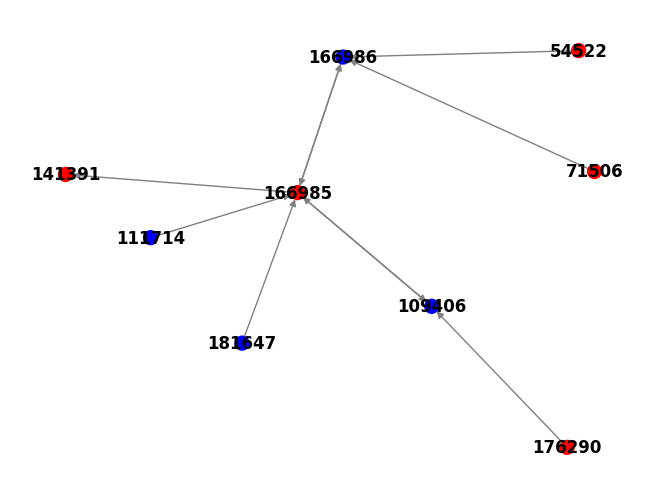

In [ ]:
pos = nx.spring_layout(subgraph )  # Positions for all nodes
nx.draw(subgraph, pos, node_color=colors, with_labels=True , font_weight='bold', node_size=100, font_size=12, edge_color='gray', width=1)
plt.show()

In [ ]:
adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()
eigenvalues, eigenvectors = np.linalg.eig(adjacency_matrix)

<ipython-input-232-ef6ba42e8d64>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()


In [ ]:
k = 1
top_eigenvectors = eigenvectors[:, :k]

# Project data onto the subspace spanned by top eigenvectors
projected_data = np.dot(adjacency_matrix, top_eigenvectors)

# Reconstruct data from projected data
reconstructed_data = np.dot(projected_data, top_eigenvectors.T)
# Compute reconstruction error
reconstruction_error =np.linalg.norm(adjacency_matrix - reconstructed_data, axis=1)

# Define threshold for anomaly detection
threshold = 0.5  # Adjust as needed
# Detect anomalies
anomalies = [i for i, error in enumerate(reconstruction_error) if error > threshold]

print("Anomalies:", anomalies)


Anomalies: [0, 1, 2, 3, 4, 6, 7, 8]


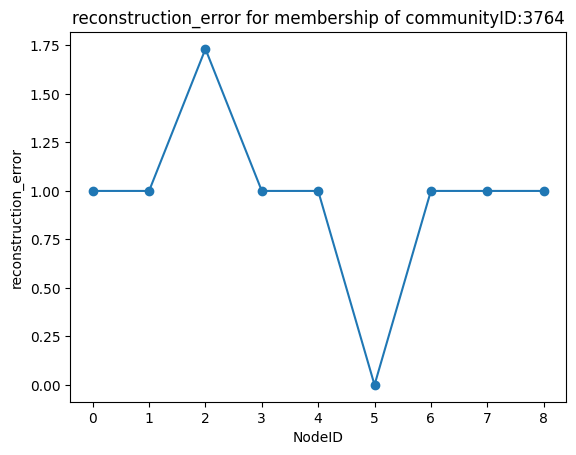

In [ ]:
AnomalNodelist=[]
for i, error in enumerate(reconstruction_error):
    item=[error]
    AnomalNodelist.append(item)
x = range(len(AnomalNodelist))

# Plot the values
plt.plot(x, AnomalNodelist, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('reconstruction_error')
plt.title('reconstruction_error for membership of communityID:3764')

# Show the plot
plt.show()

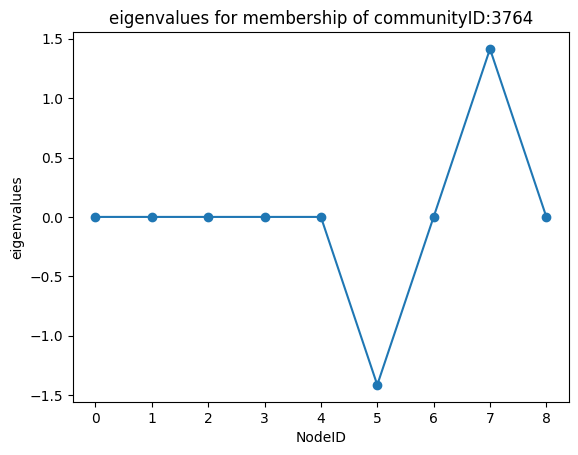

In [ ]:
x = range(len(eigenvalues))

# Plot the values
plt.plot(x, eigenvalues, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:3764')

# Show the plot
plt.show()

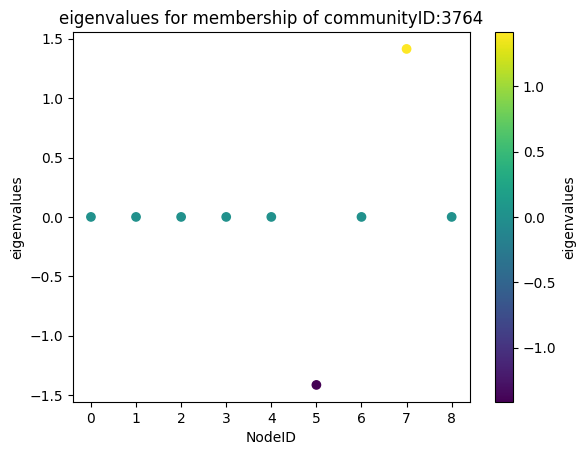

In [ ]:
AnomalNodelist=[]
for i, error in enumerate(reconstruction_error):
    item=[error]
    AnomalNodelist.append(item)
#------------------------------------------------------
x = range(len(eigenvalues))
cmap = plt.get_cmap('viridis')
plt.scatter(x, eigenvalues, c=eigenvalues, cmap=cmap)

# Add a colorbar
plt.colorbar(label='eigenvalues')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:3764')

# Show the plot
plt.show()

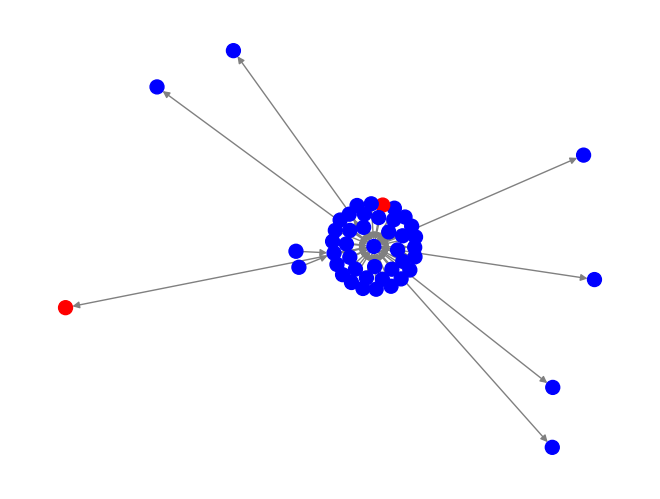

In [ ]:
subgraph_nodes = set(map(int, PartInfo[1980][1].strip('{}').split(',')))
subgraph=train_G.subgraph(subgraph_nodes)

#*****************************************************************
condition_column='NewNodeId'
condition_value=subgraph_nodes
#filtered_df =  nodedf[nodedf[condition_column].apply(lambda x: isinstance(subgraph_nodes, set))]
selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes)]
#----------------------
labels_list = selected_rows['L_alert'].values.tolist()
labels_dict = {node: label for node, label in zip(subgraph.nodes, labels_list)}
nx.set_node_attributes(subgraph, labels_dict, 'label')

node_colors = {1: 'red', 0: 'blue'}
colors = [node_colors[subgraph.nodes[node]['label']] for node in subgraph.nodes]

#--------------------------

pos = nx.spring_layout(subgraph )  # Positions for all nodes
nx.draw(subgraph, pos, node_color=colors, with_labels=False , font_weight='bold', node_size=100, font_size=12, edge_color='gray', width=1)
plt.show()

In [ ]:
adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()
eigenvalues, eigenvectors = np.linalg.eig(adjacency_matrix)
k = 1
top_eigenvectors = eigenvectors[:, :k]

# Project data onto the subspace spanned by top eigenvectors
projected_data = np.dot(adjacency_matrix, top_eigenvectors)

# Reconstruct data from projected data
reconstructed_data = np.dot(projected_data, top_eigenvectors.T)
# Compute reconstruction error
reconstruction_error =np.linalg.norm(adjacency_matrix - reconstructed_data, axis=1)

# Define threshold for anomaly detection
threshold = 0.1 # Adjust as needed
# Detect anomalies
anomalies = [i for i, error in enumerate(reconstruction_error) if error > threshold]

print("Anomalies:", anomalies)
print(len(anomalies))


Anomalies: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44, 46, 47]
41


<ipython-input-284-6a9108d2ca32>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()


In [ ]:
normal_nodes = [i for i, eigenvalue in enumerate(eigenvalues) if eigenvalue >= threshold]
new_subgraph = subgraph.copy()
new_subgraph.remove_nodes_from(normal_nodes)
print(len(normal_nodes))


1


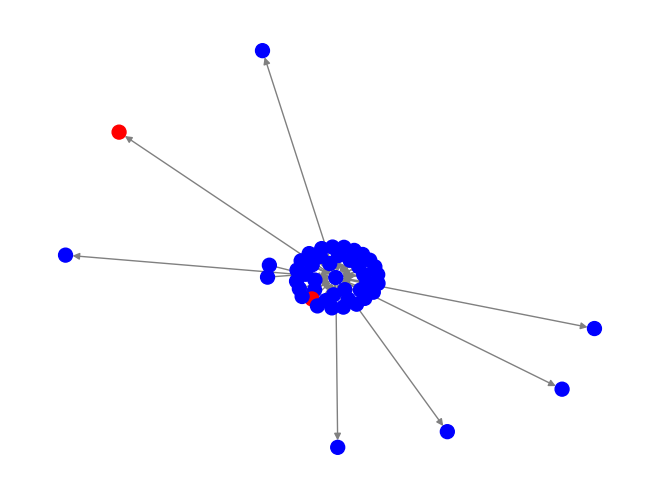

In [ ]:
subgraph_nodes_n=new_subgraph.nodes
condition_column='NewNodeId'
condition_value=subgraph_nodes
#filtered_df =  nodedf[nodedf[condition_column].apply(lambda x: isinstance(subgraph_nodes, set))]
selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes_n)]
#----------------------
labels_list = selected_rows['L_alert'].values.tolist()
labels_dict = {node: label for node, label in zip(new_subgraph.nodes, labels_list)}
nx.set_node_attributes(subgraph, labels_dict, 'label')

node_colors = {1: 'red', 0: 'blue'}
colors = [node_colors[subgraph.nodes[node]['label']] for node in new_subgraph.nodes]

#--------------------------

pos = nx.spring_layout(new_subgraph )  # Positions for all nodes
nx.draw(subgraph, pos, node_color=colors, with_labels=False , font_weight='bold', node_size=100, font_size=12, edge_color='gray', width=1)
plt.show()

In [ ]:
AnomalNodelist=[]
for i, error in enumerate(reconstruction_error):
    item=[error]
    AnomalNodelist.append(item)


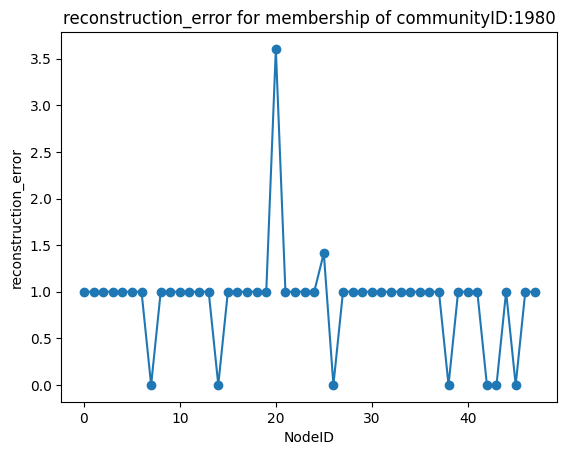

In [ ]:
x = range(len(AnomalNodelist))

# Plot the values
plt.plot(x, AnomalNodelist, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('reconstruction_error')
plt.title('reconstruction_error for membership of communityID:1980')

# Show the plot
plt.show()

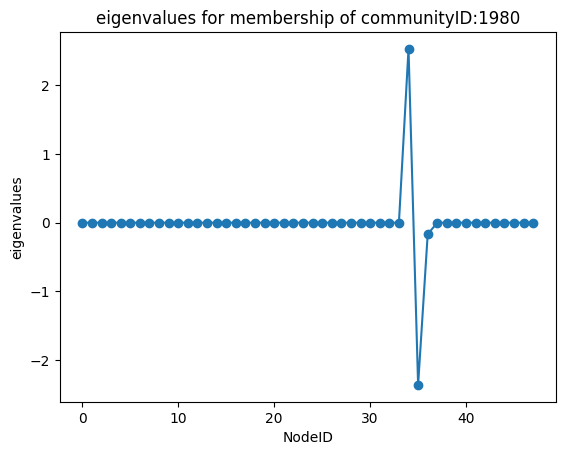

In [ ]:
x = range(len(eigenvalues))

# Plot the values
plt.plot(x, eigenvalues, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:1980')

# Show the plot
plt.show()



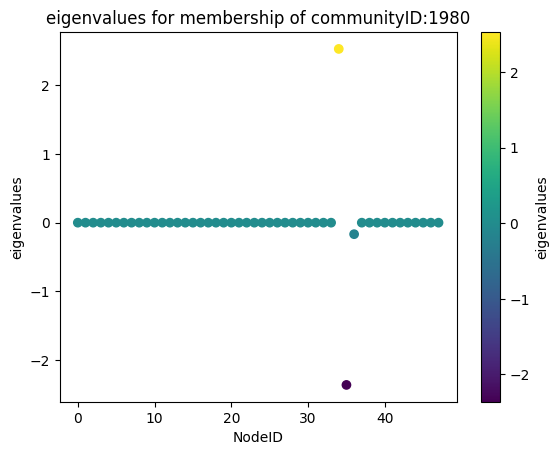

In [ ]:
x = range(len(eigenvalues))
cmap = plt.get_cmap('viridis')
plt.scatter(x, eigenvalues, c=eigenvalues, cmap=cmap)

# Add a colorbar
plt.colorbar(label='eigenvalues')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:1980')

# Show the plot
plt.show()

In [ ]:
#-------------------------------------------------------------------------------

In [ ]:
subgraph_nodes = set(map(int, PartInfo[154][1].strip('{}').split(',')))
subgraph=train_G.subgraph(subgraph_nodes)

In [ ]:
adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()
eigenvalues, eigenvectors = np.linalg.eig(adjacency_matrix)
k = 1
top_eigenvectors = eigenvectors[:, :k]

# Project data onto the subspace spanned by top eigenvectors
projected_data = np.dot(adjacency_matrix, top_eigenvectors)

# Reconstruct data from projected data
reconstructed_data = np.dot(projected_data, top_eigenvectors.T)
# Compute reconstruction error
reconstruction_error =np.linalg.norm(adjacency_matrix - reconstructed_data, axis=1)

# Define threshold for anomaly detection
threshold = 0.5  # Adjust as needed
# Detect anomalies
anomalies = [i for i, error in enumerate(reconstruction_error) if error > threshold]

print("Anomalies:", anomalies)
print(len(anomalies))

<ipython-input-251-bcfda19c791c>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()


Anomalies: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 139, 140, 141, 142, 143, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 185, 186, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 201, 202, 203, 204, 205, 206, 208, 209, 211, 213, 215, 216, 217, 218, 219, 220, 221, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 260, 261, 262, 26

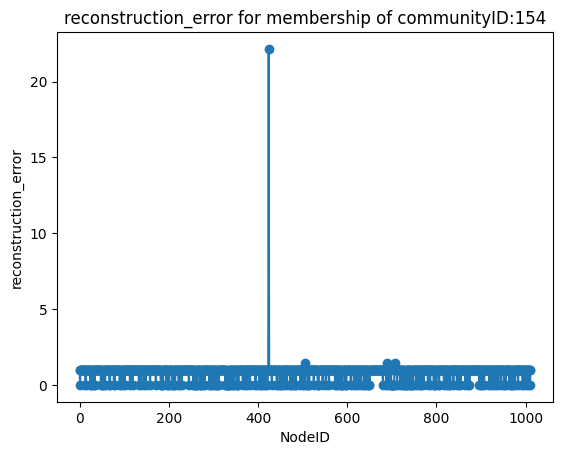

In [ ]:
AnomalNodelist=[]
for i, error in enumerate(reconstruction_error):
    item=[error]
    AnomalNodelist.append(item)
x = range(len(AnomalNodelist))

# Plot the values
plt.plot(x, AnomalNodelist, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('reconstruction_error')
plt.title('reconstruction_error for membership of communityID:154')

# Show the plot
plt.show()


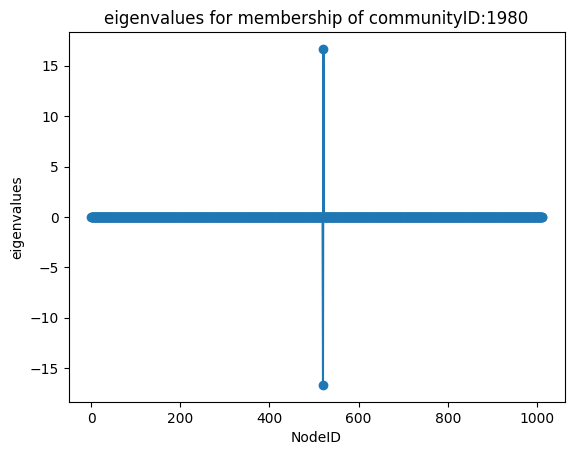

In [ ]:
x = range(len(eigenvalues))

# Plot the values
plt.plot(x, eigenvalues, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:1980')

# Show the plot
plt.show()


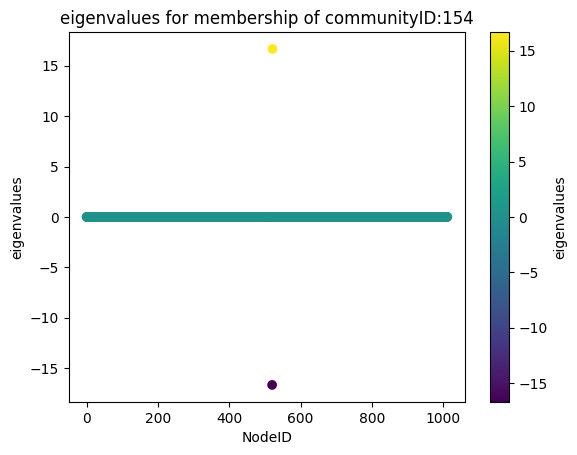

In [ ]:
x = range(len(eigenvalues))
cmap = plt.get_cmap('viridis')
plt.scatter(x, eigenvalues, c=eigenvalues, cmap=cmap)

# Add a colorbar
plt.colorbar(label='eigenvalues')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:154')

# Show the plot
plt.show()

# ACCGroup prediction with Laplacian Feature

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
import tensorflow as tf
seed=42
learning_rate=0.001
num_classes=2
in_feats = Grp_X_train.shape[1]
hid_feats = 64 # Hidden layer size
out_feats = num_classes  # Number of output classes
num_heads =1
GAGNNModel = GATModel(in_channels=in_feats, hidden_channels=hid_feats, num_classes=num_classes, heads=num_heads)
optimizer =torch.optim.Adam(GAGNNModel.parameters(), lr=learning_rate)

imbalance_ratio=8.3
class_weights = torch.tensor([1.5, imbalance_ratio])  # Adjust imbalance_ratio accordingly
#class_weights = class_weights.to(device)  # Move to GPU if available
class_weights = class_weights  # Move to GPU if available
criterion = torch.nn.CrossEntropyLoss(weight=Grp_class_weights)


batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
epochs=80
tf.random.set_seed(42)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In epoch 0, loss: 0.704)
In epoch 5, loss: 0.688)
In epoch 10, loss: 0.684)
In epoch 15, loss: 0.683)
In epoch 20, loss: 0.684)
In epoch 25, loss: 0.683)
In epoch 30, loss: 0.687)
In epoch 35, loss: 0.696)
In epoch 40, loss: 0.686)
In epoch 45, loss: 0.689)
In epoch 50, loss: 0.686)
In epoch 55, loss: 0.690)
In epoch 60, loss: 0.679)
In epoch 65, loss: 0.680)
In epoch 70, loss: 0.682)
In epoch 75, loss: 0.677)


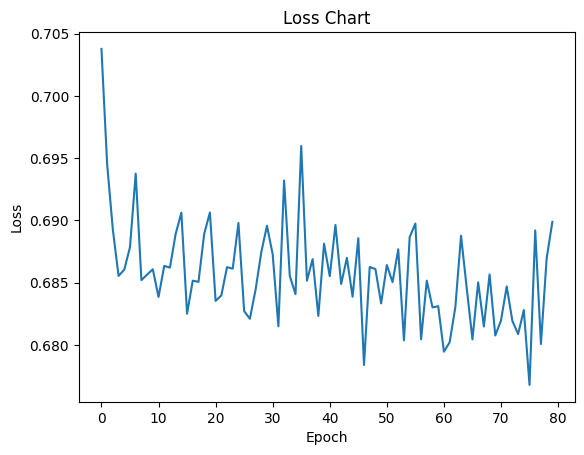

In [ ]:
torch.backends.cudnn.deterministic = True
Grp_model=train(model=GAGNNModel, train_loader=train_loader_Grp, epochs=epochs , class_weights=Grp_class_weights , learning_rate=learning_rate , edge_index=edge_index_TG)

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      2041
           1       0.05      0.28      0.09        57

    accuracy                           0.85      2098
   macro avg       0.52      0.57      0.50      2098
weighted avg       0.95      0.85      0.89      2098



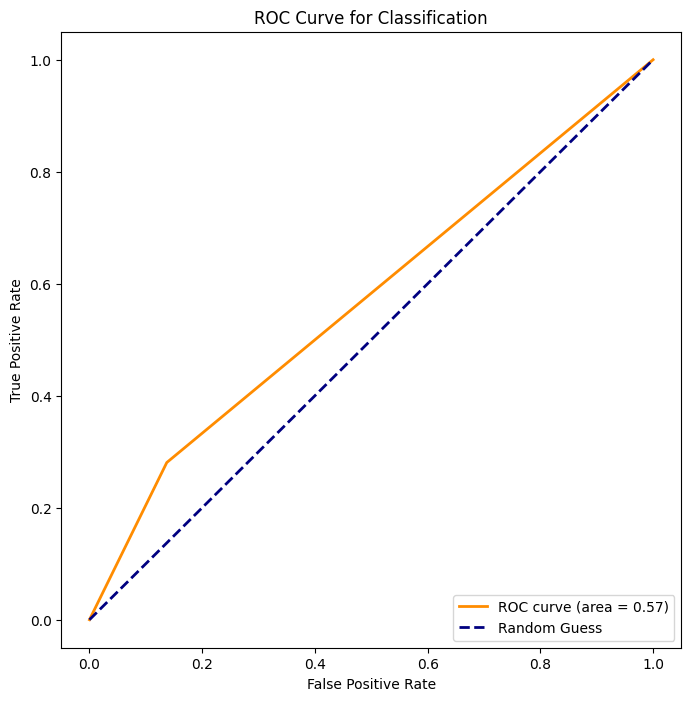

0.8469971418380737

In [ ]:
evaluate(model=Grp_model, test_loader=test_loader_Grp , edge_index=edge_index_TST )

# AccGrp Predict With Financial data :No1

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Feature_train_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_in']])
Feature_train_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_out']])

Feature_train_df['f_nr_trans_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_nr_trans_in']])
Feature_train_df['f_nr_trans_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_nr_trans_out']])

Feature_test_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_in']])
Feature_test_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_out']])
Feature_test_df['f_nr_trans_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_nr_trans_in']])
Feature_test_df['f_nr_trans_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_nr_trans_out']])

In [ ]:
Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','f_nr_trans_in_scaled','f_nr_trans_out_scaled']

In [ ]:
#featurename=['len_Community' ,'f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']
#featurename=['f_amount_in','f_amount_out', 'f_nr_trans_in','f_nr_trans_out']
Grp_X_train=torch.tensor((Feature_train_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_X_test =torch.tensor((Feature_test_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
#Grp_X_train=torch.tensor(node_features_train)
#Grp_X_test=torch.tensor(node_features_test)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
import tensorflow as tf
seed=42
learning_rate=0.01
num_classes=2
input_dim  = Grp_X_train.shape[1]
hidden_dim  = 64 # Hidden layer size
out_feats = num_classes  # Number of output classes
#num_heads =1
model = SiameseNetwork(input_dim, hidden_dim)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#GAGNNModel = GATModel(in_channels=in_feats, hidden_channels=hid_feats, num_classes=num_classes, heads=num_heads)
#optimizer =torch.optim.Adam(GAGNNModel.parameters(), lr=learning_rate)

imbalance_ratio=8.3
class_weights = torch.tensor([1.5, imbalance_ratio])  # Adjust imbalance_ratio accordingly
#class_weights = class_weights.to(device)  # Move to GPU if available
class_weights = class_weights  # Move to GPU if available
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)

#batch_size_Grp =32
#batch_size_Grp_tst =32

num_epochs =50
tf.random.set_seed(42)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
normal_data = Grp_X_train[Grp_y_train==0]
anomalous_data =Grp_X_train[Grp_y_train==1]

pairs = []
labels = []
for normal_transaction in normal_data:
    pairs.append([normal_transaction, normal_transaction])  # Pair each normal transaction with itself
    labels.append(0)  # Similarity label: 0 (similar)

for normal_transaction in normal_data:
    anomalous_transaction = anomalous_data[np.random.randint(len(anomalous_data))]  # Randomly select an anomalous transaction
    pairs.append([normal_transaction, anomalous_transaction])  # Pair a normal transaction with an anomalous one
    labels.append(1)  # Similarity label: 1 (dissimilar)

# Convert pairs and labels to numpy arrays
pairs = np.array(pairs)
labels = np.array(labels)

# Convert data to PyTorch tensors
pairs_tensor = torch.tensor(pairs, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

dataset = TransactionDataset(pairs_tensor, labels_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size_Grp, shuffle=True)

In [ ]:
for inputs, labels in train_loader:
    inputs1, inputs2 = inputs[:, 0, :], inputs[:, 1, :]
    print(labels)
    print('---------------------------------------------')
    print(inputs2)

In [ ]:
len(Grp_X_train[0])

4

In [ ]:
# Training loop
num_epochs =30
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in train_loader:
        inputs1, inputs2 = inputs[:, 0, :], inputs[:, 1, :]
        #print(len(inputs1) , len(inputs2))
        outputs = model(inputs1, inputs2)#.squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()  # Backpropagation
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

print("Training finished!")

Epoch 1, Loss: 0.18932683765888214
Epoch 2, Loss: 0.16480837017297745
Epoch 3, Loss: 0.15241986513137817
Epoch 4, Loss: 0.1444992497563362
Epoch 5, Loss: 0.13946743309497833
Epoch 6, Loss: 0.1360825151205063
Epoch 7, Loss: 0.1336258426308632
Epoch 8, Loss: 0.1319439932703972
Epoch 9, Loss: 0.1307261884212494
Epoch 10, Loss: 0.12976551055908203
Epoch 11, Loss: 0.12904243916273117
Epoch 12, Loss: 0.12846489995718002
Epoch 13, Loss: 0.1279386430978775
Epoch 14, Loss: 0.12753348052501678
Epoch 15, Loss: 0.127191960811615
Epoch 16, Loss: 0.1269570291042328
Epoch 17, Loss: 0.12670926749706268
Epoch 18, Loss: 0.1265183985233307
Epoch 19, Loss: 0.1263483390212059
Epoch 20, Loss: 0.1261892095208168
Epoch 21, Loss: 0.12603672966361046
Epoch 22, Loss: 0.12594853341579437
Epoch 23, Loss: 0.12586359679698944
Epoch 24, Loss: 0.12577274814248085
Epoch 25, Loss: 0.1257135421037674
Epoch 26, Loss: 0.12565790116786957
Epoch 27, Loss: 0.12560047209262848
Epoch 28, Loss: 0.1255650371313095
Epoch 29, Loss:

In [ ]:
normal_data_tst = Grp_X_test[Grp_y_test==0]
anomalous_data_tst =Grp_X_test[Grp_y_test==1]

pairs = []
labels = []
for normal_transaction in normal_data_tst:
    pairs.append([normal_transaction, normal_transaction])  # Pair each normal transaction with itself
    labels.append(0)  # Similarity label: 0 (similar)

for normal_transaction in normal_data_tst:
    anomalous_transaction = anomalous_data_tst[np.random.randint(len(anomalous_data_tst))]  # Randomly select an anomalous transaction
    pairs.append([normal_transaction, anomalous_transaction])  # Pair a normal transaction with an anomalous one
    labels.append(1)  # Similarity label: 1 (dissimilar)

# Convert pairs and labels to numpy arrays
pairs = np.array(pairs)
labels = np.array(labels)

# Convert data to PyTorch tensors
pairs_tensor = torch.tensor(pairs, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

dataset_tst = TransactionDataset(pairs_tensor, labels_tensor)
test_loader = DataLoader(dataset_tst, batch_size=len(pairs), shuffle=False)

In [ ]:
len(pairs)

4082

In [ ]:
def evaluate(model,test_loader) :
    torch.backends.cudnn.deterministic = True
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs1, inputs2 = inputs[:, 0, :], inputs[:, 1, :]
            logits = model(inputs1, inputs2)
            #_, predicted = torch.max(logits, 1)
            predicted = (logits > 0.5).float()

            accuracy = (predicted == labels).float().mean().item()


        print(classification_report(labels, predicted))

    #--------------------Plot AUC----------------------------
        fpr, tpr, thresholds = roc_curve(labels, predicted)

        # Calculate the AUC
        roc_auc = auc(fpr, tpr)
        # Calculate the AUC
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Classification')
        plt.legend(loc='lower right')
        plt.show()

    return roc_auc

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# def evaluate_model(siamese_net, dataloader):
#     siamese_net.eval()
#     y_true = []
#     y_pred = []

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs1, inputs2 = inputs[:, 0, :], inputs[:, 1, :]
#         #print(len(inputs1) , len(inputs2))

#             output = siamese_net(inputs1, inputs2)
#             predicted = (output > 0.5).float()  # Threshold output probabilities
#             y_true.extend(labels.numpy())
#             y_pred.extend(predicted.numpy())

#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)

#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred)
#     recall = recall_score(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred)

#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")

#     # Compute ROC curve and AUC
#     fpr, tpr, thresholds = roc_curve(y_true, y_pred)
#     auc = roc_auc_score(y_true, y_pred)
#     print(f"AUC: {auc:.4f}")

#     # Optionally, plot ROC curve
#     #import matplotlib.pyplot as plt
#     plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend()
#     plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2041
         1.0       0.50      1.00      0.67      2041

    accuracy                           0.50      4082
   macro avg       0.25      0.50      0.33      4082
weighted avg       0.25      0.50      0.33      4082



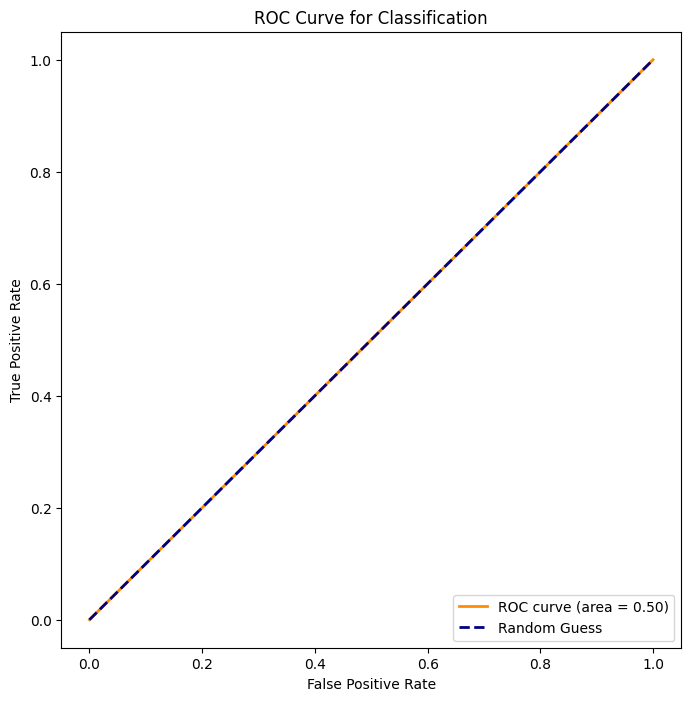

0.5

In [ ]:
evaluate(model, test_loader)

In [ ]:
evaluate(model=model, test_loader=test_loader )

#AccGrp Predict With Financial data And Laplacian Matrix

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Feature_train_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_in']])
Feature_train_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_out']])

Feature_test_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_in']])
Feature_test_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_out']])


#Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','f_nr_trans_in','f_nr_trans_out' , 'embedded_Laplacian_0','embedded_Laplacian_1' ]
Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','embedded_Laplacian_0','embedded_Laplacian_1' ]
Grp_X_train=torch.tensor((Feature_train_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_X_test =torch.tensor((Feature_test_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
import tensorflow as tf
seed=42
learning_rate=0.01
num_classes=2
in_feats = Grp_X_train.shape[1]
hid_feats = 64 # Hidden layer size
out_feats = num_classes  # Number of output classes
num_heads =1
GAGNNModel = GATModel(in_channels=in_feats, hidden_channels=hid_feats, num_classes=num_classes, heads=num_heads)
optimizer =torch.optim.Adam(GAGNNModel.parameters(), lr=learning_rate)

imbalance_ratio=8.3
class_weights = torch.tensor([1.5, imbalance_ratio])  # Adjust imbalance_ratio accordingly
#class_weights = class_weights.to(device)  # Move to GPU if available
class_weights = class_weights  # Move to GPU if available
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
epochs=50
tf.random.set_seed(42)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In epoch 0, loss: 0.697)
In epoch 5, loss: 0.580)
In epoch 10, loss: 0.590)
In epoch 15, loss: 0.570)
In epoch 20, loss: 0.565)
In epoch 25, loss: 0.554)
In epoch 30, loss: 0.564)
In epoch 35, loss: 0.552)
In epoch 40, loss: 0.554)
In epoch 45, loss: 0.563)


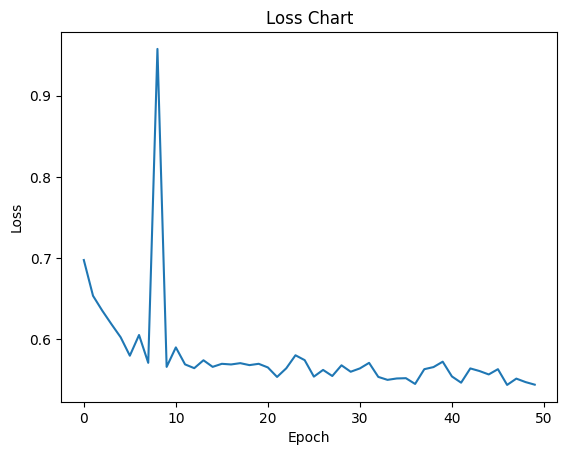

In [ ]:
torch.backends.cudnn.deterministic = True
Grp_model=train(model=GAGNNModel, train_loader=train_loader_Grp, epochs=epochs , class_weights=Grp_class_weights , learning_rate=learning_rate , edge_index=edge_index_TG)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84      2041
           1       0.08      0.91      0.15        57

    accuracy                           0.73      2098
   macro avg       0.54      0.82      0.50      2098
weighted avg       0.97      0.73      0.82      2098



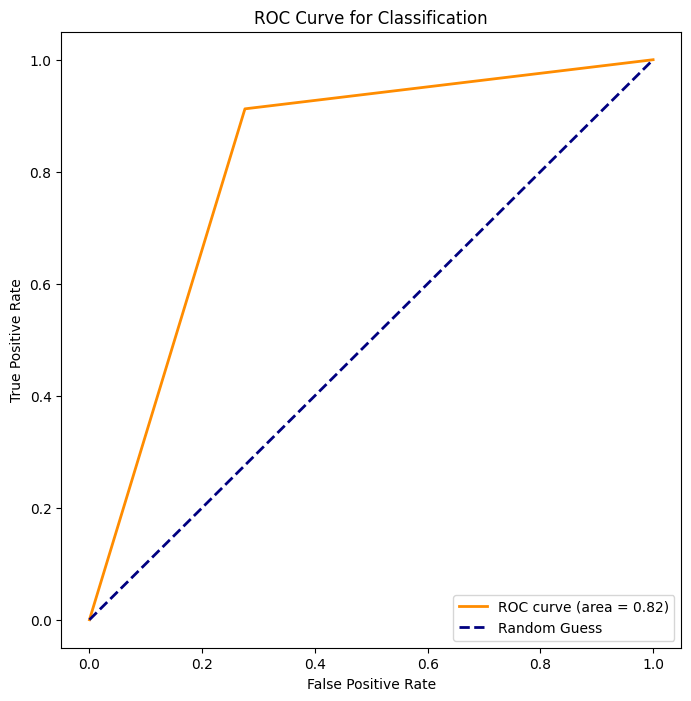

0.7292659878730774

In [ ]:
evaluate(model=Grp_model, test_loader=test_loader_Grp , edge_index=edge_index_TST )

# AccGrp Predict With Financial data And SubGraph Embedding

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Feature_train_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_in']])
Feature_train_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_out']])

Feature_test_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_in']])
Feature_test_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_out']])


#Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','f_nr_trans_in','f_nr_trans_out' , 'subgraph_embedding_0','subgraph_embedding_1' ]
Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','subgraph_embedding_0','subgraph_embedding_1' ]
Grp_X_train=torch.tensor((Feature_train_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_X_test =torch.tensor((Feature_test_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
import tensorflow as tf
seed=42
learning_rate=0.01
num_classes=2
in_feats = Grp_X_train.shape[1]
hid_feats = 100 # Hidden layer size
out_feats = num_classes  # Number of output classes
num_heads =1
GAGNNModel = GATModel(in_channels=in_feats, hidden_channels=hid_feats, num_classes=num_classes, heads=num_heads)
optimizer =torch.optim.Adam(GAGNNModel.parameters(), lr=learning_rate)

imbalance_ratio=8.3
class_weights = torch.tensor([1.5, imbalance_ratio])  # Adjust imbalance_ratio accordingly
#class_weights = class_weights.to(device)  # Move to GPU if available
class_weights = class_weights  # Move to GPU if available
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
epochs=50
tf.random.set_seed(42)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In epoch 0, loss: 0.733)
In epoch 5, loss: 0.646)
In epoch 10, loss: 0.772)
In epoch 15, loss: 0.600)
In epoch 20, loss: 0.558)
In epoch 25, loss: 0.540)
In epoch 30, loss: 0.595)
In epoch 35, loss: 0.544)
In epoch 40, loss: 0.549)
In epoch 45, loss: 0.557)


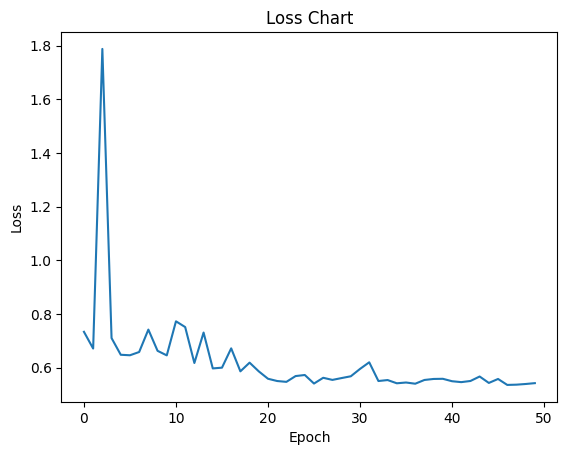

In [ ]:
torch.backends.cudnn.deterministic = True
Grp_model=train(model=GAGNNModel, train_loader=train_loader_Grp, epochs=epochs , class_weights=Grp_class_weights , learning_rate=learning_rate , edge_index=edge_index_TG)

              precision    recall  f1-score   support

           0       1.00      0.69      0.82      2041
           1       0.08      0.93      0.14        57

    accuracy                           0.70      2098
   macro avg       0.54      0.81      0.48      2098
weighted avg       0.97      0.70      0.80      2098



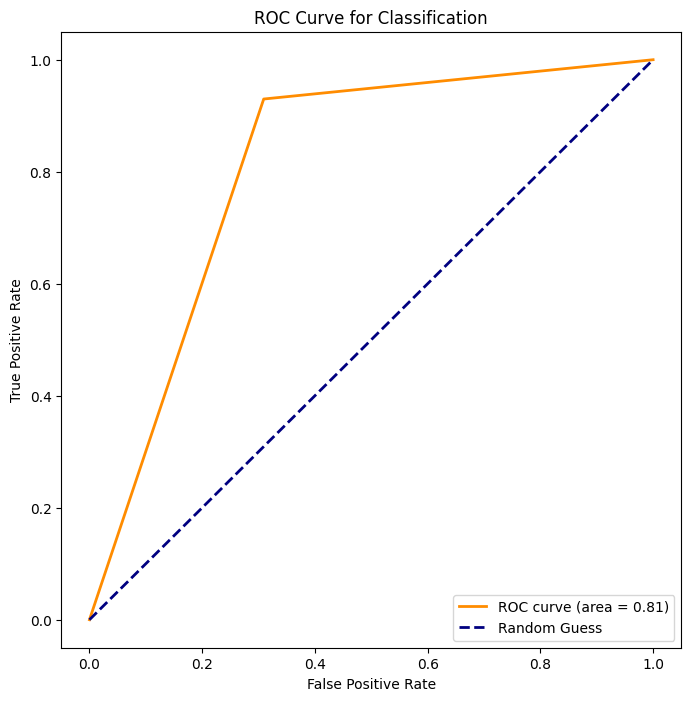

0.6973307728767395

In [ ]:
evaluate(model=Grp_model, test_loader=test_loader_Grp , edge_index=edge_index_TST)

# ACCGroup prediction with Subgraph embedding Feature

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Feature_train_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_in']])
Feature_train_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_out']])

Feature_test_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_in']])
Feature_test_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_out']])


#Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','f_nr_trans_in','f_nr_trans_out' , 'subgraph_embedding_0','subgraph_embedding_1' ]
Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0','embedded_Laplacian_1' ]
Grp_X_train=torch.tensor((Feature_train_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_X_test =torch.tensor((Feature_test_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
import tensorflow as tf
seed=42
learning_rate=0.01
num_classes=2
in_feats = Grp_X_train.shape[1]
hid_feats = 64 # Hidden layer size
out_feats = num_classes  # Number of output classes
num_heads =1
GAGNNModel = GATModel(in_channels=in_feats, hidden_channels=hid_feats, num_classes=num_classes, heads=num_heads)
optimizer =torch.optim.Adam(GAGNNModel.parameters(), lr=learning_rate)

imbalance_ratio=8.3
class_weights = torch.tensor([1.5, imbalance_ratio])  # Adjust imbalance_ratio accordingly
#class_weights = class_weights.to(device)  # Move to GPU if available
class_weights = class_weights  # Move to GPU if available
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
epochs=50
tf.random.set_seed(42)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In epoch 0, loss: 0.704)
In epoch 5, loss: 0.589)
In epoch 10, loss: 0.614)
In epoch 15, loss: 0.566)
In epoch 20, loss: 0.552)
In epoch 25, loss: 0.570)
In epoch 30, loss: 0.579)
In epoch 35, loss: 0.550)
In epoch 40, loss: 0.554)
In epoch 45, loss: 0.558)


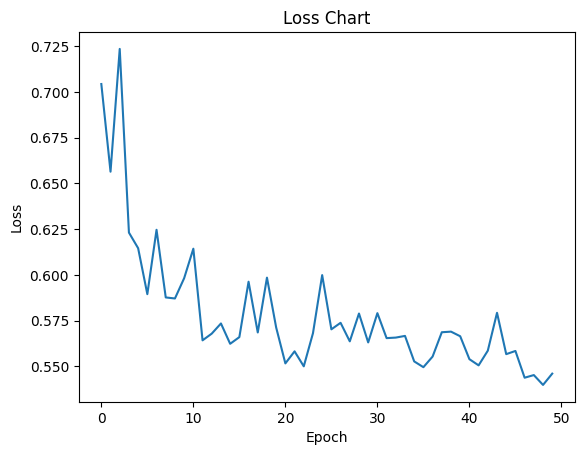

In [ ]:
torch.backends.cudnn.deterministic = True
Grp_model=train(model=GAGNNModel, train_loader=train_loader_Grp, epochs=epochs , class_weights=Grp_class_weights , learning_rate=learning_rate , edge_index=edge_index_TG)

              precision    recall  f1-score   support

           0       1.00      0.70      0.82      2041
           1       0.08      0.91      0.15        57

    accuracy                           0.71      2098
   macro avg       0.54      0.81      0.49      2098
weighted avg       0.97      0.71      0.81      2098



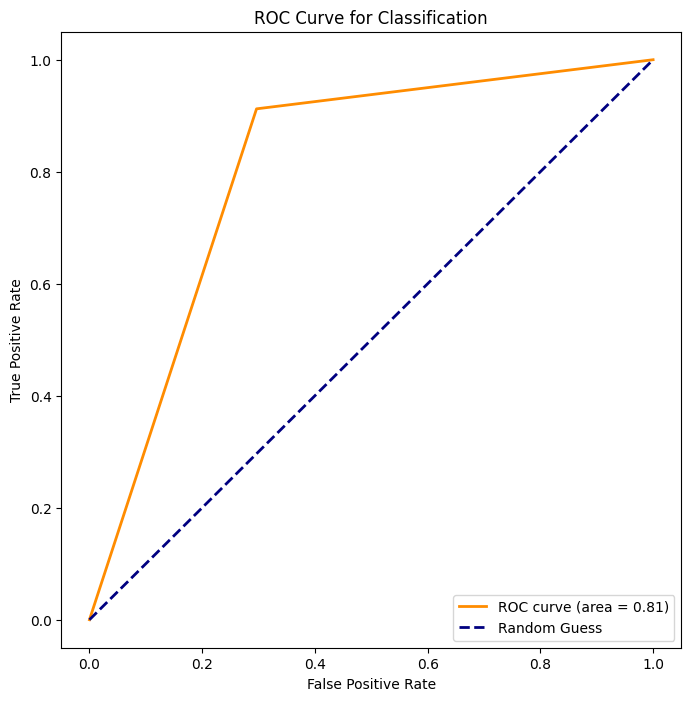

0.7092468738555908

In [ ]:
evaluate(model=Grp_model, test_loader=test_loader_Grp , edge_index=edge_index_TST )

# Model For Multi Task Learning with Different Feature

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Feature_train_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_in']])
Feature_train_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_out']])

Feature_test_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_in']])
Feature_test_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_out']])

Col_Feature_sub=['subgraph_embedding_0','subgraph_embedding_1']
#Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0','embedded_Laplacian_1' ]
F_TST_df=Feature_test_df[Col_Feature_sub]
Grpsub_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
Grpsub_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

F_TR_df=Feature_train_df[Col_Feature_sub]
Grpsub_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
Grpsub_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
#-------------------------------------------------------------------------------------------
Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled' , 'f_nr_trans_in','f_nr_trans_out']
F_TST_df=Feature_test_df[Col_Feature_Final]
GrpFI_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
GrpFI_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

F_TR_df=Feature_train_df[Col_Feature_Final]
GrpFI_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
GrpFI_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
#--------------------------------------------------------------------------------------------
Col_Feature_LP=['embedded_Laplacian_0','embedded_Laplacian_1'  ]
F_TST_df=Feature_test_df[Col_Feature_LP]
GrpLP_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
GrpLP_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

F_TR_df=Feature_train_df[Col_Feature_LP]
GrpLP_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
GrpLP_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)


In [ ]:
G_class_weights=Get_class_weights(Grpsub_y_train)
batch_size_TR= len(Grpsub_X_train)
batch_size_TST= len(Grpsub_X_test)

In [ ]:
#Sub_learning_rate=0.09
train_dateset=torch.utils.data.TensorDataset(Grpsub_X_train,Grpsub_y_train)
train_loader_subGrp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_TR, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grpsub_X_test,Grpsub_y_test)
test_loader_subGrp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_TST, shuffle=False )
#----------------------------------------------------
#FI_learning_rate=0.003
train_dateset=torch.utils.data.TensorDataset(GrpFI_X_train,GrpFI_y_train)
train_loader_FIGrp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_TR, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(GrpFI_X_test,GrpFI_y_test)
test_loader_FIGrp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_TST, shuffle=False )
#----------------------------------------------------
#LP_learning_rate=0.2
train_dateset=torch.utils.data.TensorDataset(GrpLP_X_train,GrpLP_y_train)
train_loader_LPGrp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_TR, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(GrpLP_X_test,GrpLP_y_test)
test_loader_LPGrp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_TST, shuffle=False )



In [ ]:
Grpsub_X_train.shape[1]

2

In [ ]:
criterion = nn.CrossEntropyLoss(weight=G_class_weights)

In [ ]:
learning_rate=0.01
num_classes=2
in_feats = Grp_X_train.shape[1]
hid_feats_SubGrp = 16 # Hidden layer size
hid_feats_FIGrp = 64
hid_feats_LPGrp = 16
out_feats = num_classes  # Number of output classes
num_heads =1

in_feats_SubG=2
in_feats_FI=4
in_feats_Lp=2




In [ ]:
GAGNNModel_GrpSub = GATModel(in_channels=in_feats_SubG, hidden_channels=hid_feats_SubGrp, num_classes=num_classes, heads=num_heads)
GAGNNModel_GrpFI = GATModel(in_channels=in_feats_FI, hidden_channels=hid_feats_FIGrp, num_classes=num_classes, heads=num_heads)
GAGNNModel_GrpLp = GATModel(in_channels=in_feats_Lp, hidden_channels=hid_feats_LPGrp, num_classes=num_classes, heads=num_heads)

optimizer = optim.Adam(list(GAGNNModel_GrpSub.parameters()) + list(GAGNNModel_GrpFI.parameters()) + list(GAGNNModel_GrpLp.parameters()) , lr=learning_rate)
#optimizer = optim.Adam(list(GAGNNModel_GrpSub.parameters()) + list(GAGNNModel_GrpLp.parameters()) , lr=learning_rate)

In [ ]:
# Training loop
torch.backends.cudnn.deterministic = True
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    GrpSub_logits = GAGNNModel_GrpSub(Grpsub_X_train, edge_index_TG)
    GrpFI_logits = GAGNNModel_GrpFI(GrpFI_X_train, edge_index_TG)
    GrpLp_logits = GAGNNModel_GrpLp(GrpLP_X_train, edge_index_TG)

    # Compute losses
    GrpSub_loss = criterion(GrpSub_logits, Grpsub_y_train)
    GrpFI_loss = criterion(GrpFI_logits, GrpFI_y_train)
    GrpLp_loss = criterion(GrpLp_logits, GrpLP_y_train)

    # Total loss (you can weight the losses if needed)
    total_loss = GrpSub_loss + GrpLp_loss + GrpFI_loss
    loss_mean = torch.mean(total_loss)
    # Backpropagation
    #total_loss.backward()
    loss_mean.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, SubGraph Loss: {GrpSub_loss.item()}, FI Loss: {GrpFI_loss.item()} , LP Loss: {GrpLp_loss.item()}')

Epoch 1/50, SubGraph Loss: 0.6901744604110718, FI Loss: 4961.88134765625 , LP Loss: 0.7120766043663025
Epoch 6/50, SubGraph Loss: 0.6864867210388184, FI Loss: 3.317800521850586 , LP Loss: 0.6848390102386475
Epoch 11/50, SubGraph Loss: 0.6857748031616211, FI Loss: 3.739802122116089 , LP Loss: 0.676348090171814
Epoch 16/50, SubGraph Loss: 0.6851966381072998, FI Loss: 3.4222497940063477 , LP Loss: 0.663193941116333
Epoch 21/50, SubGraph Loss: 0.684299886226654, FI Loss: 3.0528807640075684 , LP Loss: 0.6621852517127991
Epoch 26/50, SubGraph Loss: 0.6835988163948059, FI Loss: 3.053947687149048 , LP Loss: 0.6611935496330261
Epoch 31/50, SubGraph Loss: 0.6826908588409424, FI Loss: 3.1461594104766846 , LP Loss: 0.6593081951141357
Epoch 36/50, SubGraph Loss: 0.6815400719642639, FI Loss: 3.1221296787261963 , LP Loss: 0.6575607061386108
Epoch 41/50, SubGraph Loss: 0.6799662709236145, FI Loss: 3.01491379737854 , LP Loss: 0.656517744064331
Epoch 46/50, SubGraph Loss: 0.6776012778282166, FI Loss: 2.

              precision    recall  f1-score   support

           0       0.99      0.30      0.46      2041
           1       0.03      0.84      0.06        57

    accuracy                           0.31      2098
   macro avg       0.51      0.57      0.26      2098
weighted avg       0.96      0.31      0.45      2098



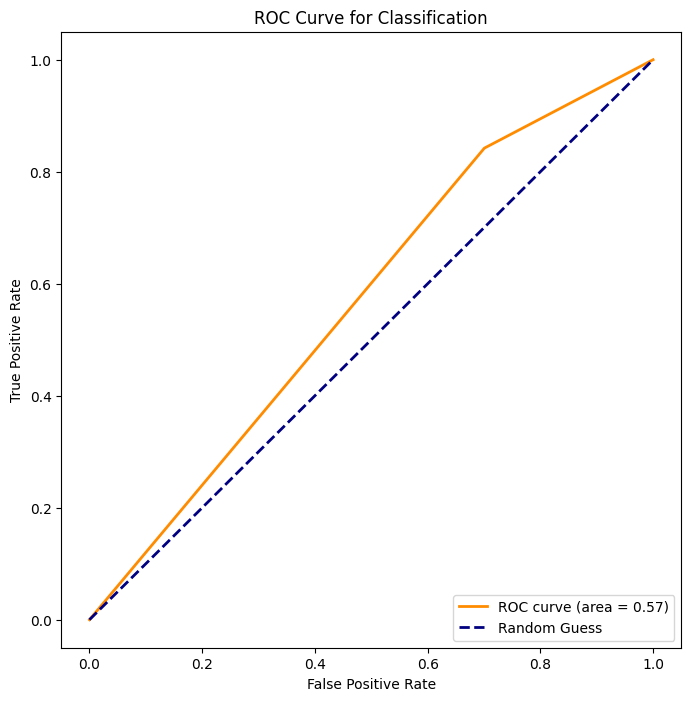

0.314108669757843

In [ ]:
evaluate(model=GAGNNModel_GrpFI, test_loader=test_loader_FIGrp , edge_index=edge_index_TST )

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2041
           1       0.06      0.16      0.09        57

    accuracy                           0.91      2098
   macro avg       0.52      0.55      0.52      2098
weighted avg       0.95      0.91      0.93      2098



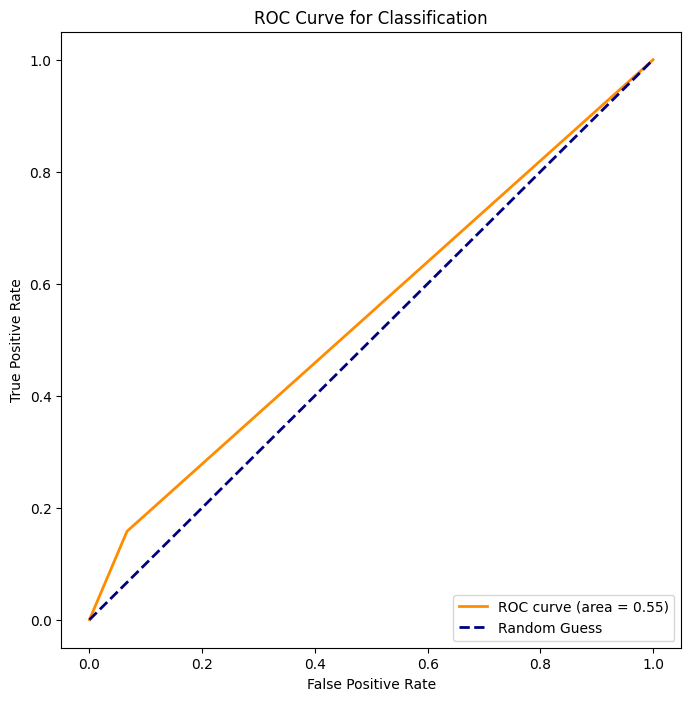

0.9122974276542664

In [ ]:
evaluate(model=GAGNNModel_GrpLp, test_loader=test_loader_LPGrp , edge_index=edge_index_TST )

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2041
           1       0.07      0.30      0.11        57

    accuracy                           0.87      2098
   macro avg       0.52      0.59      0.52      2098
weighted avg       0.95      0.87      0.91      2098



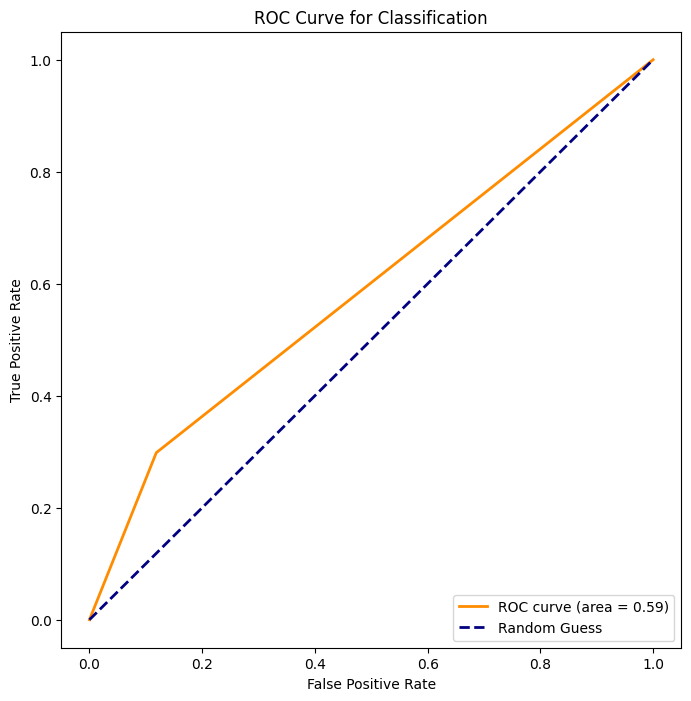

0.8655862808227539

In [ ]:
evaluate(model=GAGNNModel_GrpSub, test_loader=test_loader_subGrp , edge_index=edge_index_TST )

#Multi Task

In [ ]:
train_graph=dgl.DGLGraph(train_G)
test_graph=dgl.DGLGraph(test_G)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [ ]:
edge_list_src, edge_list_dst = train_graph.edges()
edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
train_edge_index = torch.cat((edge_list_src.unsqueeze(0), edge_list_dst.unsqueeze(0)), dim=0)
train_edge_index=torch.tensor(train_edge_index ,dtype=torch.long)

<ipython-input-381-23476a1285d8>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
<ipython-input-381-23476a1285d8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
<ipython-input-381-23476a1285d8>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_edge_index=torch.tensor(train_edge_index ,dtype=torch.long)


In [ ]:
edge_list_src, edge_list_dst = test_graph.edges()
edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
test_edge_index = torch.cat((edge_list_src.unsqueeze(0), edge_list_dst.unsqueeze(0)), dim=0)
test_edge_index=torch.tensor(test_edge_index ,dtype=torch.long)

<ipython-input-382-c210dc5d2f2c>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
<ipython-input-382-c210dc5d2f2c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
<ipython-input-382-c210dc5d2f2c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_edge_index=torch.tensor(test_edge_index ,dtype=torch.long)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Feature_train_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_in']])
Feature_train_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_out']])

Feature_test_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_in']])
Feature_test_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_out']])

#Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0','embedded_Laplacian_1'  ]
Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0','embedded_Laplacian_1']
F_TST_df=Feature_test_df[Col_Feature_Final]
Grpsub_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
Grpsub_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

F_TR_df=Feature_train_df[Col_Feature_Final]
Grpsub_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
Grpsub_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
traindata_df['f_amount_in_scaled'] = scaler.fit_transform(traindata_df[['f_amount_in']])
traindata_df['f_amount_out_scaled'] = scaler.fit_transform(traindata_df[['f_amount_out']])

testdata_df['f_amount_in_scaled'] = scaler.fit_transform(testdata_df[['f_amount_in']])
testdata_df['f_amount_out_scaled'] = scaler.fit_transform(testdata_df[['f_amount_out']])
featurName=['f_amount_in_scaled','f_amount_out_scaled','f_nr_trans_in','f_nr_trans_out']
X_train_Node=traindata_df[featurName].values.tolist()
y_train_Node=traindata_df['L_alert'].values
node_features = torch.tensor(X_train_Node ,dtype=torch.float)
node_labels = torch.tensor(y_train_Node ,dtype=torch.long)

X_test_Node=testdata_df[featurName].values.tolist()
y_test_Node=testdata_df['L_alert'].values
X_test_Node = torch.tensor(X_test_Node ,dtype=torch.float)
y_test_Node = torch.tensor(y_test_Node ,dtype=torch.long)

In [ ]:
node_features.shape

torch.Size([135447, 4])

In [ ]:
test_edgelist_G['cum_amount_scaled'] = scaler.fit_transform(test_edgelist_G[['cum_amount']])
train_edgelist_G['cum_amount_scaled'] = scaler.fit_transform(train_edgelist_G[['cum_amount']])

featurName=['cum_amount_scaled','nr_transactions']
X_train_e=train_edgelist_G[featurName].values.tolist()
y_train_e=train_edgelist_G['eLabel'].values
edge_features = torch.tensor(X_train_e ,dtype=torch.float)
edge_labels = torch.tensor(y_train_e ,dtype=torch.long)

X_test_tensor_e=test_edgelist_G[featurName].values.tolist()
y_test_tensor_e=test_edgelist_G['eLabel'].values
X_test_tensor_e = torch.tensor(X_test_tensor_e ,dtype=torch.float)
y_test_tensor_e = torch.tensor(y_test_tensor_e ,dtype=torch.long)

In [ ]:
e_class_weights=Get_class_weights(edge_labels)
n_class_weights=Get_class_weights(node_labels)
Grp_class_weights=Get_class_weights(Grpsub_y_train)


In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grpsub_X_train,Grpsub_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=len(Grpsub_X_train), shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grpsub_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=len(Grp_X_test), shuffle=False )
#----------------------------------------------------

train_dateset=torch.utils.data.TensorDataset(node_features,node_labels)
train_loader_node=torch.utils.data.DataLoader(train_dateset , batch_size=len(node_features), shuffle=True)
test_dataset=torch.utils.data.TensorDataset(X_test_Node,y_test_Node)
test_loader_node=torch.utils.data.DataLoader(test_dataset , batch_size=len(X_test_Node), shuffle=False )
#----------------------------------------------------
train_dateset_e=torch.utils.data.TensorDataset(edge_features,edge_labels)
train_loader_e=torch.utils.data.DataLoader(train_dateset_e , batch_size=len(edge_features), shuffle=True)
test_dataset_e=torch.utils.data.TensorDataset(X_test_tensor_e,y_test_tensor_e)
test_loader_e=torch.utils.data.DataLoader(test_dataset_e , batch_size=len(X_test_tensor_e), shuffle=False )

In [ ]:
node_criterion = nn.CrossEntropyLoss(weight=n_class_weights)
Grp_criterion = nn.CrossEntropyLoss(weight=Grp_class_weights)
edge_criterion = nn.CrossEntropyLoss(weight=e_class_weights)

In [ ]:
in_feats_e=2
in_feats_n=4
in_feats_grp=6

hid_feats_n=100


hid_feats_e=32
hid_feats_Grp=64
learning_rate=0.01


GAGNNModel_e = GATModel(in_channels=in_feats_e, hidden_channels=hid_feats_e, num_classes=num_classes, heads=num_heads)
GAGNNModel_n = GATModel(in_channels=in_feats_n, hidden_channels=hid_feats_n, num_classes=num_classes, heads=num_heads)
Grp_GAGNNModel = GATModel(in_channels=in_feats_grp, hidden_channels=hid_feats_Grp, num_classes=num_classes, heads=num_heads)
optimizer = optim.Adam(list(GAGNNModel_n.parameters()) + list(GAGNNModel_e.parameters()) + list(Grp_GAGNNModel.parameters()), lr=learning_rate)

In [ ]:
# Training loop
torch.backends.cudnn.deterministic = True
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    Grp_logits = Grp_GAGNNModel(Grpsub_X_train , edge_index_TG)
    edge_logits = GAGNNModel_e(edge_features, train_edge_index)
    node_logits = GAGNNModel_n(node_features, train_edge_index)

    # Compute losses
    Grp_loss = node_criterion(Grp_logits, Grpsub_y_train)
    edge_loss = edge_criterion(edge_logits, edge_labels.long())
    node_loss = node_criterion(node_logits, node_labels)

    # Total loss (you can weight the losses if needed)
    total_loss =  Grp_loss + node_loss + edge_loss
    #loss_mean = torch.mean(total_loss)

    # Backpropagation
    total_loss.backward()
    #loss_mean.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Edge Loss: {edge_loss.item()} , Grp Loss: {Grp_loss.item()}')

Epoch 1/50, Edge Loss: 0.24200275540351868 , Grp Loss: 0.30417391657829285
Epoch 6/50, Edge Loss: 0.22763822972774506 , Grp Loss: 0.3015231490135193
Epoch 11/50, Edge Loss: 0.2162993997335434 , Grp Loss: 0.2986434996128082
Epoch 16/50, Edge Loss: 0.2062128782272339 , Grp Loss: 0.2958981394767761
Epoch 21/50, Edge Loss: 0.19736945629119873 , Grp Loss: 0.29309046268463135
Epoch 26/50, Edge Loss: 0.18961362540721893 , Grp Loss: 0.2902672588825226
Epoch 31/50, Edge Loss: 0.18315593898296356 , Grp Loss: 0.28746354579925537
Epoch 36/50, Edge Loss: 0.1776975393295288 , Grp Loss: 0.28466787934303284
Epoch 41/50, Edge Loss: 0.1730223447084427 , Grp Loss: 0.2818547785282135
Epoch 46/50, Edge Loss: 0.16885773837566376 , Grp Loss: 0.2790664732456207


              precision    recall  f1-score   support

           0       1.00      0.75      0.85      2041
           1       0.09      0.93      0.17        57

    accuracy                           0.75      2098
   macro avg       0.55      0.84      0.51      2098
weighted avg       0.97      0.75      0.84      2098



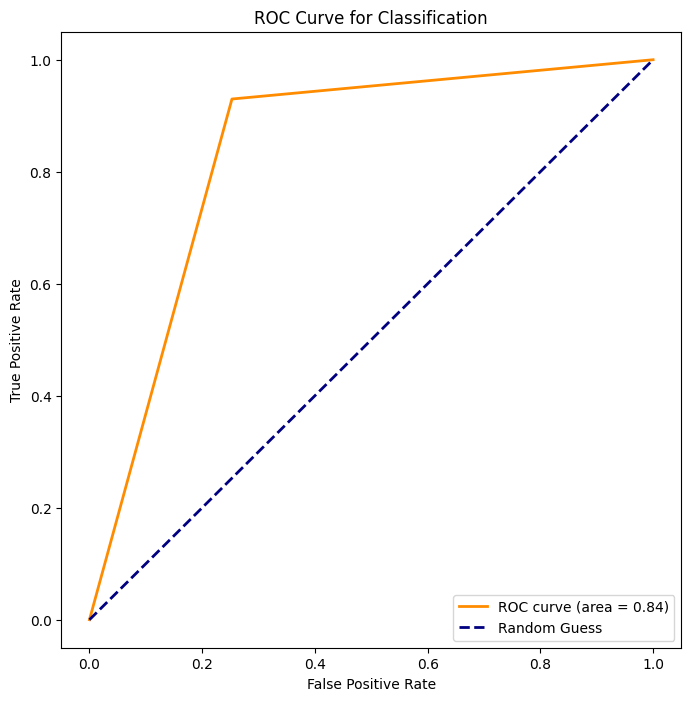

0.7521448731422424

In [ ]:
evaluate(model=Grp_GAGNNModel, test_loader=test_loader_Grp , edge_index = edge_index_TST)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     16196
           1       0.04      1.00      0.08        26

    accuracy                           0.96     16222
   macro avg       0.52      0.98      0.53     16222
weighted avg       1.00      0.96      0.98     16222



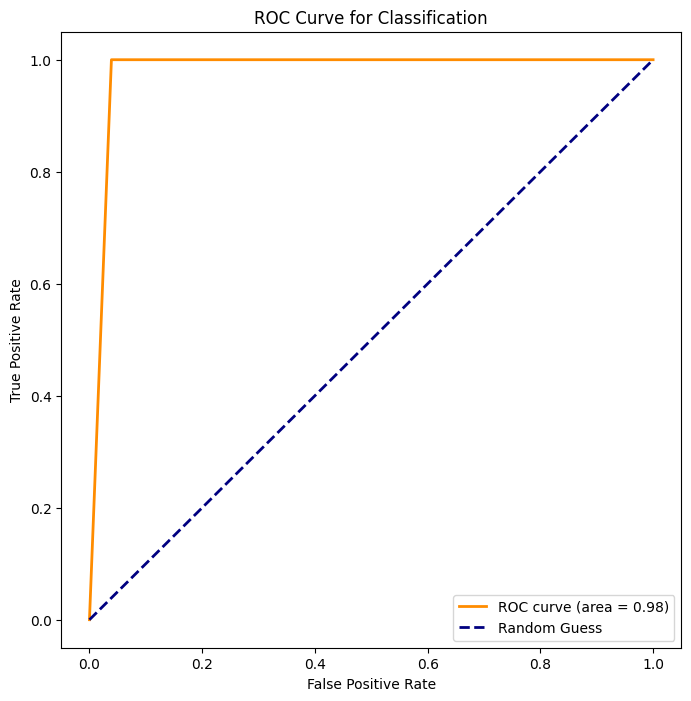

0.9611021876335144

In [ ]:
evaluate(model=GAGNNModel_e, test_loader=test_loader_e , edge_index = test_edge_index)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     12889
           1       0.09      0.78      0.15        74

    accuracy                           0.95     12963
   macro avg       0.54      0.87      0.56     12963
weighted avg       0.99      0.95      0.97     12963



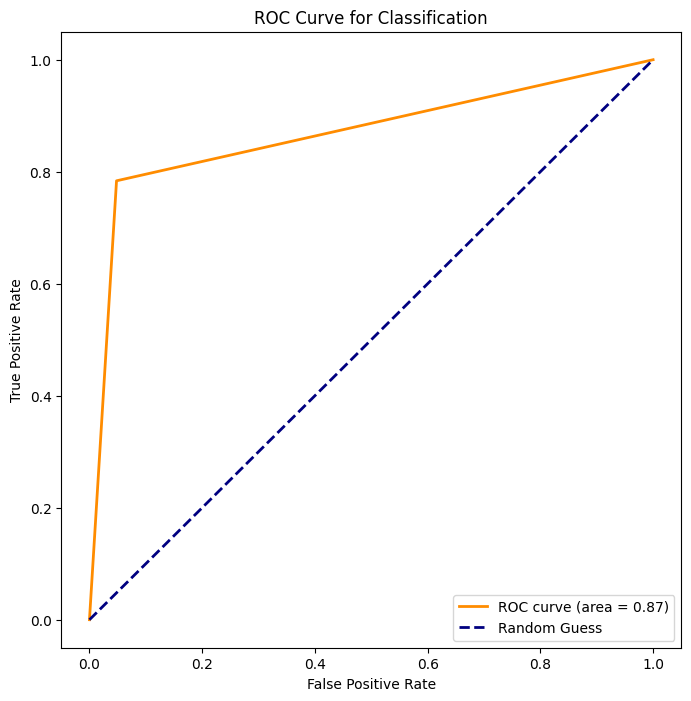

0.9510143995285034

In [ ]:
evaluate(model=GAGNNModel_n, test_loader=test_loader_node , edge_index = test_edge_index)

# Multi Model with Multi Feature

In [ ]:
train_graph=dgl.DGLGraph(train_G)
test_graph=dgl.DGLGraph(test_G)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [ ]:
edge_list_src, edge_list_dst = train_graph.edges()
edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
train_edge_index = torch.cat((edge_list_src.unsqueeze(0), edge_list_dst.unsqueeze(0)), dim=0)
train_edge_index=torch.tensor(train_edge_index ,dtype=torch.long)

<ipython-input-37-23476a1285d8>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
<ipython-input-37-23476a1285d8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
<ipython-input-37-23476a1285d8>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_edge_index=torch.tensor(train_edge_index ,dtype=torch.long)


In [ ]:
edge_list_src, edge_list_dst = test_graph.edges()
edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
test_edge_index = torch.cat((edge_list_src.unsqueeze(0), edge_list_dst.unsqueeze(0)), dim=0)
test_edge_index=torch.tensor(test_edge_index ,dtype=torch.long)

<ipython-input-38-c210dc5d2f2c>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
<ipython-input-38-c210dc5d2f2c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
<ipython-input-38-c210dc5d2f2c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_edge_index=torch.tensor(test_edge_index ,dtype=torch.long)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Feature_train_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_in']])
Feature_train_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_out']])

Feature_test_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_in']])
Feature_test_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_out']])

#Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0','embedded_Laplacian_1'  ]
Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled',  'embedded_Laplacian_0','embedded_Laplacian_1']
F_TST_df=Feature_test_df[Col_Feature_Final]
GrpFI_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

F_TR_df=Feature_train_df[Col_Feature_Final]
GrpFI_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
Col_Feature_S=['subgraph_embedding_0','subgraph_embedding_1' , 'f_amount_in_scaled','f_amount_out_scaled']
F_TST_df=Feature_test_df[Col_Feature_S]
Grpsub_X_test_s=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
F_TR_df=Feature_train_df[Col_Feature_S]
Grpsub_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)

In [ ]:
#------------------------------Node Prediction---------------------------------------------
traindata_df['f_amount_in_scaled'] = scaler.fit_transform(traindata_df[['f_amount_in']])
traindata_df['f_amount_out_scaled'] = scaler.fit_transform(traindata_df[['f_amount_out']])

testdata_df['f_amount_in_scaled'] = scaler.fit_transform(testdata_df[['f_amount_in']])
testdata_df['f_amount_out_scaled'] = scaler.fit_transform(testdata_df[['f_amount_out']])
featurName=['f_amount_in_scaled','f_amount_out_scaled','f_nr_trans_in','f_nr_trans_out']
X_train_Node=traindata_df[featurName].values.tolist()
y_train_Node=traindata_df['L_alert'].values
node_features = torch.tensor(X_train_Node ,dtype=torch.float)
node_labels = torch.tensor(y_train_Node ,dtype=torch.long)

X_test_Node=testdata_df[featurName].values.tolist()
y_test_Node=testdata_df['L_alert'].values
X_test_Node = torch.tensor(X_test_Node ,dtype=torch.float)
y_test_Node = torch.tensor(y_test_Node ,dtype=torch.long)

In [ ]:
#------------------------------Edge Prediction---------------------------------------------
test_edgelist_G['cum_amount_scaled'] = scaler.fit_transform(test_edgelist_G[['cum_amount']])
train_edgelist_G['cum_amount_scaled'] = scaler.fit_transform(train_edgelist_G[['cum_amount']])

featurName=['cum_amount_scaled','nr_transactions']
X_train_e=train_edgelist_G[featurName].values.tolist()
y_train_e=train_edgelist_G['eLabel'].values
edge_features = torch.tensor(X_train_e ,dtype=torch.float)
edge_labels = torch.tensor(y_train_e ,dtype=torch.long)

X_test_tensor_e=test_edgelist_G[featurName].values.tolist()
y_test_tensor_e=test_edgelist_G['eLabel'].values
X_test_tensor_e = torch.tensor(X_test_tensor_e ,dtype=torch.float)
y_test_tensor_e = torch.tensor(y_test_tensor_e ,dtype=torch.long)

In [ ]:
e_class_weights=Get_class_weights(edge_labels)
n_class_weights=Get_class_weights(node_labels)
Grp_class_weights=Get_class_weights(Grp_y_train)


In [ ]:
train_dateset=torch.utils.data.TensorDataset(Grpsub_X_train,Grp_y_train)
train_loader_GrpSub=torch.utils.data.DataLoader(train_dateset , batch_size=len(Grpsub_X_train), shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grpsub_X_test_s,Grp_y_test)
test_loader_GrpSub=torch.utils.data.DataLoader(test_dataset , batch_size=len(Grp_X_test), shuffle=False )

train_dateset=torch.utils.data.TensorDataset(GrpFI_X_train,Grp_y_train)
train_loader_GrpFI=torch.utils.data.DataLoader(train_dateset , batch_size=len(Grpsub_X_train), shuffle=True)
test_dataset=torch.utils.data.TensorDataset(GrpFI_X_test,Grp_y_test)
test_loader_GrpFI=torch.utils.data.DataLoader(test_dataset , batch_size=len(Grp_X_test), shuffle=False )


#----------------------------------------------------

train_dateset=torch.utils.data.TensorDataset(node_features,node_labels)
train_loader_node=torch.utils.data.DataLoader(train_dateset , batch_size=len(node_features), shuffle=True)
test_dataset=torch.utils.data.TensorDataset(X_test_Node,y_test_Node)
test_loader_node=torch.utils.data.DataLoader(test_dataset , batch_size=len(X_test_Node), shuffle=False )
#----------------------------------------------------
train_dateset_e=torch.utils.data.TensorDataset(edge_features,edge_labels)
train_loader_e=torch.utils.data.DataLoader(train_dateset_e , batch_size=len(edge_features), shuffle=True)
test_dataset_e=torch.utils.data.TensorDataset(X_test_tensor_e,y_test_tensor_e)
test_loader_e=torch.utils.data.DataLoader(test_dataset_e , batch_size=len(X_test_tensor_e), shuffle=False )

In [ ]:
node_criterion = nn.CrossEntropyLoss(weight=n_class_weights)
Grp_criterion = nn.CrossEntropyLoss(weight=Grp_class_weights)
edge_criterion = nn.CrossEntropyLoss(weight=e_class_weights)

In [ ]:
in_feats_e=2
in_feats_n=4
in_feats_grpSub=4
in_feats_grpFI=4
hid_feats_n=100
num_classes=2
num_heads=1
hid_feats_e=32

learning_rate=0.03

hid_feats_GrpFI=64
hid_feats_GrpSub=16
#hid_feats_GrpLP=32

GATModel_e = GATModel(in_channels=in_feats_e, hidden_channels=hid_feats_e, num_classes=num_classes, heads=num_heads)
GATModel_n = GATModel(in_channels=in_feats_n, hidden_channels=hid_feats_n, num_classes=num_classes, heads=num_heads)
GrpFI_GATModel = GATModel(in_channels=in_feats_grpFI, hidden_channels=hid_feats_GrpFI, num_classes=num_classes, heads=num_heads)
GrpSub_GATModel = GATModel(in_channels=in_feats_grpSub, hidden_channels=hid_feats_GrpSub, num_classes=num_classes, heads=num_heads)


optimizer = optim.Adam(list(GATModel_e.parameters()) + list(GATModel_n.parameters()) +
                       list(GrpFI_GATModel.parameters()) +
                        list(GrpSub_GATModel.parameters())
                       , lr=learning_rate)



In [ ]:
# Training loop
torch.backends.cudnn.deterministic = True
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    Grp_logitsFI = GrpFI_GATModel(GrpFI_X_train , edge_index_TG)
    Grp_logitsSub = GrpSub_GATModel(Grpsub_X_train , edge_index_TG)
    #Grp_logitsLP = Grp_eMRFModelLP(GrpLP_X_train , edge_index_TG)

    edge_logits = GATModel_e(edge_features, train_edge_index)
    node_logits = GATModel_n(node_features, train_edge_index)

    # Compute losses
    Grp_lossFI = node_criterion(Grp_logitsFI, Grp_y_train)
    Grp_lossSub = node_criterion(Grp_logitsSub, Grp_y_train)
    #Grp_lossLP = node_criterion(Grp_logitsLP, Grp_y_train)

    edge_loss = edge_criterion(edge_logits, edge_labels.long())
    node_loss = node_criterion(node_logits, node_labels)

    # Total loss (you can weight the losses if needed)

    total_loss =  node_loss + edge_loss + Grp_lossSub + Grp_lossFI
    loss_mean = torch.mean(total_loss)

    # Backpropagation
    #total_loss.backward()
    loss_mean.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Edge Loss: {edge_loss.item()} , GrpSub Loss: {Grp_lossSub.item()} ,  GrpFI Loss: {Grp_lossFI.item()} ')

Epoch 1/50, Edge Loss: 0.6016136407852173 , GrpSub Loss: 0.46090927720069885 ,  GrpFI Loss: 1.7391700744628906 
Epoch 6/50, Edge Loss: 0.4586488604545593 , GrpSub Loss: 0.351334810256958 ,  GrpFI Loss: 0.3554615080356598 
Epoch 11/50, Edge Loss: 0.32094645500183105 , GrpSub Loss: 0.3345101773738861 ,  GrpFI Loss: 0.3424134850502014 
Epoch 16/50, Edge Loss: 0.24321146309375763 , GrpSub Loss: 0.32777002453804016 ,  GrpFI Loss: 0.3486456274986267 
Epoch 21/50, Edge Loss: 0.18373216688632965 , GrpSub Loss: 0.3208463191986084 ,  GrpFI Loss: 0.34018760919570923 
Epoch 26/50, Edge Loss: 0.14580470323562622 , GrpSub Loss: 0.3131800889968872 ,  GrpFI Loss: 0.32873228192329407 
Epoch 31/50, Edge Loss: 0.1264551728963852 , GrpSub Loss: 0.30538442730903625 ,  GrpFI Loss: 0.31706222891807556 
Epoch 36/50, Edge Loss: 0.11679616570472717 , GrpSub Loss: 0.29930150508880615 ,  GrpFI Loss: 0.30770981311798096 
Epoch 41/50, Edge Loss: 0.11006977409124374 , GrpSub Loss: 0.2932433485984802 ,  GrpFI Loss: 0

              precision    recall  f1-score   support

           0       1.00      0.71      0.83      2041
           1       0.08      0.95      0.15        57

    accuracy                           0.71      2098
   macro avg       0.54      0.83      0.49      2098
weighted avg       0.97      0.71      0.81      2098



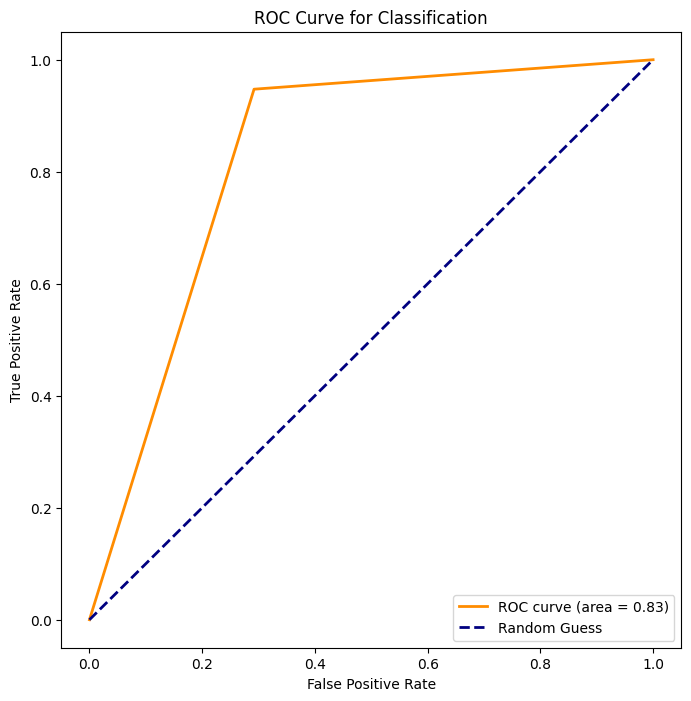

0.7144899964332581

In [ ]:
evaluate(model=GrpFI_GATModel, test_loader=test_loader_GrpFI , edge_index = edge_index_TST)

              precision    recall  f1-score   support

           0       1.00      0.71      0.83      2041
           1       0.08      0.95      0.15        57

    accuracy                           0.72      2098
   macro avg       0.54      0.83      0.49      2098
weighted avg       0.97      0.72      0.81      2098



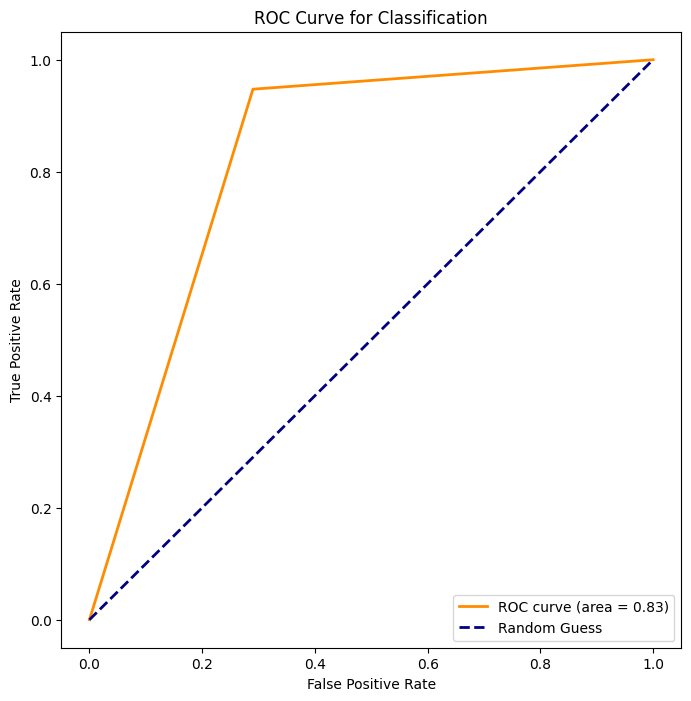

0.7163965702056885

In [ ]:
evaluate(model=GrpSub_GATModel, test_loader=test_loader_GrpSub , edge_index = edge_index_TST)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     16196
           1       0.04      1.00      0.08        26

    accuracy                           0.96     16222
   macro avg       0.52      0.98      0.53     16222
weighted avg       1.00      0.96      0.98     16222



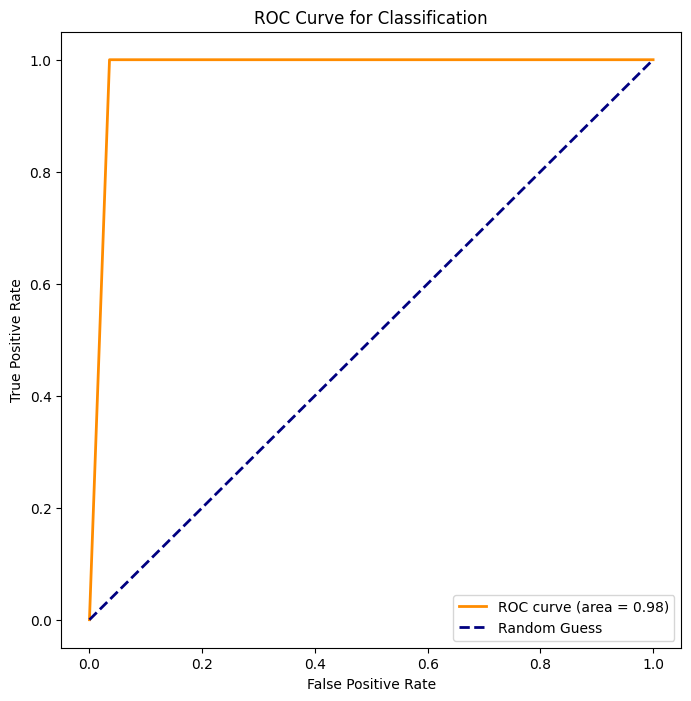

0.964492678642273

In [ ]:
evaluate(model=GATModel_e, test_loader=test_loader_e , edge_index = test_edge_index)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     12889
           1       0.08      0.81      0.14        74

    accuracy                           0.94     12963
   macro avg       0.54      0.88      0.56     12963
weighted avg       0.99      0.94      0.97     12963



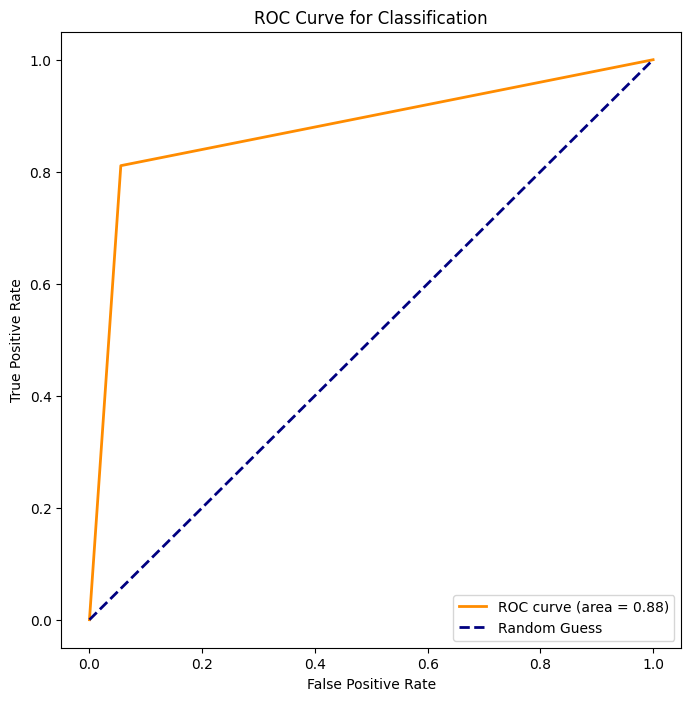

0.9436087608337402

In [ ]:
evaluate(model=GATModel_n, test_loader=test_loader_node , edge_index = test_edge_index)